# Afriat

In [1]:
ood_seed = 13

In [2]:
num_ood = 1  # not functioning

In [3]:
obs_key = "zone"

In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [8]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('30.0', 'Pericentral', 'Infected')

Removed datapoint: 182


In [9]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [10]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: h88g5s12
Name: civilized-shuttle-401
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/h88g5s12
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_104506-h88g5s12/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4324,10773
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1078,2696
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:10<1:44:22, 10.45s/it]

Epoch 1/600:   0%|          | 1/600 [00:10<1:44:22, 10.45s/it, v_num=12_1, total_loss_train=3.69e+3, kl_local_train=51.6]

Epoch 2/600:   0%|          | 1/600 [00:10<1:44:22, 10.45s/it, v_num=12_1, total_loss_train=3.69e+3, kl_local_train=51.6]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:41,  8.70s/it, v_num=12_1, total_loss_train=3.69e+3, kl_local_train=51.6]

Epoch 2/600:   0%|          | 2/600 [00:17<1:26:41,  8.70s/it, v_num=12_1, total_loss_train=3.23e+3, kl_local_train=76.9]

Epoch 3/600:   0%|          | 2/600 [00:17<1:26:41,  8.70s/it, v_num=12_1, total_loss_train=3.23e+3, kl_local_train=76.9]

Epoch 3/600:   0%|          | 3/600 [00:25<1:20:24,  8.08s/it, v_num=12_1, total_loss_train=3.23e+3, kl_local_train=76.9]

Epoch 3/600:   0%|          | 3/600 [00:25<1:20:24,  8.08s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=79.3]

Epoch 4/600:   0%|          | 3/600 [00:25<1:20:24,  8.08s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=79.3]

Epoch 4/600:   1%|          | 4/600 [00:32<1:17:09,  7.77s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=79.3]

Epoch 4/600:   1%|          | 4/600 [00:32<1:17:09,  7.77s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=76.9]

Epoch 5/600:   1%|          | 4/600 [00:32<1:17:09,  7.77s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=76.9]

Epoch 5/600:   1%|          | 5/600 [00:39<1:15:43,  7.64s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=76.9]

Epoch 5/600:   1%|          | 5/600 [00:39<1:15:43,  7.64s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=71.2]

Epoch 6/600:   1%|          | 5/600 [00:39<1:15:43,  7.64s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=71.2]

Epoch 6/600:   1%|          | 6/600 [00:47<1:14:10,  7.49s/it, v_num=12_1, total_loss_train=3.22e+3, kl_local_train=71.2]

Epoch 6/600:   1%|          | 6/600 [00:47<1:14:10,  7.49s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=62.3]

Epoch 7/600:   1%|          | 6/600 [00:47<1:14:10,  7.49s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=62.3]

Epoch 7/600:   1%|          | 7/600 [00:56<1:18:33,  7.95s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=62.3]

Epoch 7/600:   1%|          | 7/600 [00:56<1:18:33,  7.95s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=50.8]

Epoch 8/600:   1%|          | 7/600 [00:56<1:18:33,  7.95s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=50.8]

Epoch 8/600:   1%|▏         | 8/600 [01:03<1:17:28,  7.85s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=50.8]

Epoch 8/600:   1%|▏         | 8/600 [01:03<1:17:28,  7.85s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=36.7]

Epoch 9/600:   1%|▏         | 8/600 [01:03<1:17:28,  7.85s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=36.7]

Epoch 9/600:   2%|▏         | 9/600 [01:10<1:15:33,  7.67s/it, v_num=12_1, total_loss_train=3.21e+3, kl_local_train=36.7]

Epoch 9/600:   2%|▏         | 9/600 [01:10<1:15:33,  7.67s/it, v_num=12_1, total_loss_train=3.2e+3, kl_local_train=46.4] 

Epoch 10/600:   2%|▏         | 9/600 [01:10<1:15:33,  7.67s/it, v_num=12_1, total_loss_train=3.2e+3, kl_local_train=46.4]

Epoch 10/600:   2%|▏         | 10/600 [01:18<1:13:55,  7.52s/it, v_num=12_1, total_loss_train=3.2e+3, kl_local_train=46.4]

Epoch 10/600:   2%|▏         | 10/600 [01:18<1:13:55,  7.52s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=87.9]

Epoch 11/600:   2%|▏         | 10/600 [01:18<1:13:55,  7.52s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=87.9]

Epoch 11/600:   2%|▏         | 11/600 [01:25<1:12:54,  7.43s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=87.9]

Epoch 11/600:   2%|▏         | 11/600 [01:25<1:12:54,  7.43s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=140] 

Epoch 12/600:   2%|▏         | 11/600 [01:25<1:12:54,  7.43s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=140]

Epoch 12/600:   2%|▏         | 12/600 [01:32<1:12:17,  7.38s/it, v_num=12_1, total_loss_train=3.19e+3, kl_local_train=140]

Epoch 12/600:   2%|▏         | 12/600 [01:32<1:12:17,  7.38s/it, v_num=12_1, total_loss_train=3.18e+3, kl_local_train=202]

Epoch 13/600:   2%|▏         | 12/600 [01:32<1:12:17,  7.38s/it, v_num=12_1, total_loss_train=3.18e+3, kl_local_train=202]

Epoch 13/600:   2%|▏         | 13/600 [01:39<1:12:05,  7.37s/it, v_num=12_1, total_loss_train=3.18e+3, kl_local_train=202]

Epoch 13/600:   2%|▏         | 13/600 [01:39<1:12:05,  7.37s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=260]

Epoch 14/600:   2%|▏         | 13/600 [01:39<1:12:05,  7.37s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=260]

Epoch 14/600:   2%|▏         | 14/600 [01:47<1:12:14,  7.40s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=260]

Epoch 14/600:   2%|▏         | 14/600 [01:47<1:12:14,  7.40s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=301]

Epoch 15/600:   2%|▏         | 14/600 [01:47<1:12:14,  7.40s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=301]

Epoch 15/600:   2%|▎         | 15/600 [01:54<1:12:16,  7.41s/it, v_num=12_1, total_loss_train=3.17e+3, kl_local_train=301]

Epoch 15/600:   2%|▎         | 15/600 [01:54<1:12:16,  7.41s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=360]

Epoch 16/600:   2%|▎         | 15/600 [01:54<1:12:16,  7.41s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=360]

Epoch 16/600:   3%|▎         | 16/600 [02:02<1:11:57,  7.39s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=360]

Epoch 16/600:   3%|▎         | 16/600 [02:02<1:11:57,  7.39s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=374]

Epoch 17/600:   3%|▎         | 16/600 [02:02<1:11:57,  7.39s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=374]

Epoch 17/600:   3%|▎         | 17/600 [02:09<1:11:37,  7.37s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=374]

Epoch 17/600:   3%|▎         | 17/600 [02:09<1:11:37,  7.37s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=405]

Epoch 18/600:   3%|▎         | 17/600 [02:09<1:11:37,  7.37s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=405]

Epoch 18/600:   3%|▎         | 18/600 [02:16<1:11:31,  7.37s/it, v_num=12_1, total_loss_train=3.16e+3, kl_local_train=405]

Epoch 18/600:   3%|▎         | 18/600 [02:16<1:11:31,  7.37s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=426]

Epoch 19/600:   3%|▎         | 18/600 [02:16<1:11:31,  7.37s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=426]

Epoch 19/600:   3%|▎         | 19/600 [02:24<1:11:01,  7.33s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=426]

Epoch 19/600:   3%|▎         | 19/600 [02:24<1:11:01,  7.33s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=433]

Epoch 20/600:   3%|▎         | 19/600 [02:24<1:11:01,  7.33s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=433]

Epoch 20/600:   3%|▎         | 20/600 [02:31<1:10:33,  7.30s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=433]

Epoch 20/600:   3%|▎         | 20/600 [02:31<1:10:33,  7.30s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=448]

Epoch 21/600:   3%|▎         | 20/600 [02:31<1:10:33,  7.30s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=448]

Epoch 21/600:   4%|▎         | 21/600 [02:38<1:10:23,  7.29s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=448]

Epoch 21/600:   4%|▎         | 21/600 [02:38<1:10:23,  7.29s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=402]

Epoch 22/600:   4%|▎         | 21/600 [02:38<1:10:23,  7.29s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=402]

Epoch 22/600:   4%|▎         | 22/600 [02:46<1:10:27,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=402]

Epoch 22/600:   4%|▎         | 22/600 [02:46<1:10:27,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=395]

Epoch 23/600:   4%|▎         | 22/600 [02:46<1:10:27,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=395]

Epoch 23/600:   4%|▍         | 23/600 [02:53<1:10:16,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=395]

Epoch 23/600:   4%|▍         | 23/600 [02:53<1:10:16,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=373]

Epoch 24/600:   4%|▍         | 23/600 [02:53<1:10:16,  7.31s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=373]

Epoch 24/600:   4%|▍         | 24/600 [03:00<1:10:14,  7.32s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=373]

Epoch 24/600:   4%|▍         | 24/600 [03:00<1:10:14,  7.32s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=363]

Epoch 25/600:   4%|▍         | 24/600 [03:00<1:10:14,  7.32s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=363]

Epoch 25/600:   4%|▍         | 25/600 [03:08<1:10:20,  7.34s/it, v_num=12_1, total_loss_train=3.15e+3, kl_local_train=363]

Epoch 25/600:   4%|▍         | 25/600 [03:08<1:10:20,  7.34s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=355]

Epoch 26/600:   4%|▍         | 25/600 [03:08<1:10:20,  7.34s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=355]

Epoch 26/600:   4%|▍         | 26/600 [03:15<1:09:59,  7.32s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=355]

Epoch 26/600:   4%|▍         | 26/600 [03:15<1:09:59,  7.32s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=291]

Epoch 27/600:   4%|▍         | 26/600 [03:15<1:09:59,  7.32s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=291]

Epoch 27/600:   4%|▍         | 27/600 [03:22<1:10:03,  7.34s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=291]

Epoch 27/600:   4%|▍         | 27/600 [03:22<1:10:03,  7.34s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=250]

Epoch 28/600:   4%|▍         | 27/600 [03:22<1:10:03,  7.34s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=250]

Epoch 28/600:   5%|▍         | 28/600 [03:29<1:09:26,  7.28s/it, v_num=12_1, total_loss_train=3.14e+3, kl_local_train=250]

Epoch 28/600:   5%|▍         | 28/600 [03:29<1:09:26,  7.28s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=228]

Epoch 29/600:   5%|▍         | 28/600 [03:29<1:09:26,  7.28s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=228]

Epoch 29/600:   5%|▍         | 29/600 [03:37<1:08:58,  7.25s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=228]

Epoch 29/600:   5%|▍         | 29/600 [03:37<1:08:58,  7.25s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=200]

Epoch 30/600:   5%|▍         | 29/600 [03:37<1:08:58,  7.25s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=200]

Epoch 30/600:   5%|▌         | 30/600 [03:44<1:08:45,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=200]

Epoch 30/600:   5%|▌         | 30/600 [03:44<1:08:45,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=174]

Epoch 31/600:   5%|▌         | 30/600 [03:44<1:08:45,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=174]

Epoch 31/600:   5%|▌         | 31/600 [03:51<1:08:39,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=174]

Epoch 31/600:   5%|▌         | 31/600 [03:51<1:08:39,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=150]

Epoch 32/600:   5%|▌         | 31/600 [03:51<1:08:39,  7.24s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=150]

Epoch 32/600:   5%|▌         | 32/600 [03:58<1:08:43,  7.26s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=150]

Epoch 32/600:   5%|▌         | 32/600 [03:58<1:08:43,  7.26s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=139]

Epoch 33/600:   5%|▌         | 32/600 [03:58<1:08:43,  7.26s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=139]

Epoch 33/600:   6%|▌         | 33/600 [04:06<1:08:41,  7.27s/it, v_num=12_1, total_loss_train=3.13e+3, kl_local_train=139]

Epoch 33/600:   6%|▌         | 33/600 [04:06<1:08:41,  7.27s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=135]

Epoch 34/600:   6%|▌         | 33/600 [04:06<1:08:41,  7.27s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=135]

Epoch 34/600:   6%|▌         | 34/600 [04:13<1:08:43,  7.29s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=135]

Epoch 34/600:   6%|▌         | 34/600 [04:13<1:08:43,  7.29s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=125]

Epoch 35/600:   6%|▌         | 34/600 [04:13<1:08:43,  7.29s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=125]

Epoch 35/600:   6%|▌         | 35/600 [04:20<1:08:13,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=125]

Epoch 35/600:   6%|▌         | 35/600 [04:20<1:08:13,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 36/600:   6%|▌         | 35/600 [04:20<1:08:13,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 36/600:   6%|▌         | 36/600 [04:27<1:08:11,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=116]

Epoch 36/600:   6%|▌         | 36/600 [04:27<1:08:11,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 37/600:   6%|▌         | 36/600 [04:27<1:08:11,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 37/600:   6%|▌         | 37/600 [04:35<1:07:57,  7.24s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=114]

Epoch 37/600:   6%|▌         | 37/600 [04:35<1:07:57,  7.24s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 38/600:   6%|▌         | 37/600 [04:35<1:07:57,  7.24s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 38/600:   6%|▋         | 38/600 [04:42<1:07:56,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 38/600:   6%|▋         | 38/600 [04:42<1:07:56,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 39/600:   6%|▋         | 38/600 [04:42<1:07:56,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 39/600:   6%|▋         | 39/600 [04:49<1:07:45,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 39/600:   6%|▋         | 39/600 [04:49<1:07:45,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 40/600:   6%|▋         | 39/600 [04:49<1:07:45,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 40/600:   7%|▋         | 40/600 [04:56<1:07:39,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 40/600:   7%|▋         | 40/600 [04:56<1:07:39,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=105]

Epoch 41/600:   7%|▋         | 40/600 [04:56<1:07:39,  7.25s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=105]

Epoch 41/600:   7%|▋         | 41/600 [05:04<1:07:20,  7.23s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=105]

Epoch 41/600:   7%|▋         | 41/600 [05:04<1:07:20,  7.23s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 42/600:   7%|▋         | 41/600 [05:04<1:07:20,  7.23s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 42/600:   7%|▋         | 42/600 [05:11<1:08:09,  7.33s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 42/600:   7%|▋         | 42/600 [05:11<1:08:09,  7.33s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=100]

Epoch 43/600:   7%|▋         | 42/600 [05:11<1:08:09,  7.33s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=100]

Epoch 43/600:   7%|▋         | 43/600 [05:18<1:08:11,  7.34s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=100]

Epoch 43/600:   7%|▋         | 43/600 [05:18<1:08:11,  7.34s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=98.6]

Epoch 44/600:   7%|▋         | 43/600 [05:18<1:08:11,  7.34s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=98.6]

Epoch 44/600:   7%|▋         | 44/600 [05:26<1:08:03,  7.34s/it, v_num=12_1, total_loss_train=3.12e+3, kl_local_train=98.6]

Epoch 44/600:   7%|▋         | 44/600 [05:26<1:08:03,  7.34s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 45/600:   7%|▋         | 44/600 [05:26<1:08:03,  7.34s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 45/600:   8%|▊         | 45/600 [05:33<1:07:35,  7.31s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 45/600:   8%|▊         | 45/600 [05:33<1:07:35,  7.31s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 46/600:   8%|▊         | 45/600 [05:33<1:07:35,  7.31s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 46/600:   8%|▊         | 46/600 [05:40<1:07:06,  7.27s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 46/600:   8%|▊         | 46/600 [05:40<1:07:06,  7.27s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 47/600:   8%|▊         | 46/600 [05:40<1:07:06,  7.27s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 47/600:   8%|▊         | 47/600 [05:47<1:06:43,  7.24s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 47/600:   8%|▊         | 47/600 [05:47<1:06:43,  7.24s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 48/600:   8%|▊         | 47/600 [05:47<1:06:43,  7.24s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 48/600:   8%|▊         | 48/600 [05:55<1:06:30,  7.23s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 48/600:   8%|▊         | 48/600 [05:55<1:06:30,  7.23s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=95.2]

Epoch 49/600:   8%|▊         | 48/600 [05:55<1:06:30,  7.23s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=95.2]

Epoch 49/600:   8%|▊         | 49/600 [06:02<1:06:17,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=95.2]

Epoch 49/600:   8%|▊         | 49/600 [06:02<1:06:17,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=96.5]

Epoch 50/600:   8%|▊         | 49/600 [06:02<1:06:17,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=96.5]

Epoch 50/600:   8%|▊         | 50/600 [06:09<1:06:09,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=96.5]

Epoch 50/600:   8%|▊         | 50/600 [06:09<1:06:09,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 51/600:   8%|▊         | 50/600 [06:09<1:06:09,  7.22s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 51/600:   8%|▊         | 51/600 [06:17<1:08:30,  7.49s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=94.2]

Epoch 51/600:   8%|▊         | 51/600 [06:17<1:08:30,  7.49s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=90.6]

Epoch 52/600:   8%|▊         | 51/600 [06:17<1:08:30,  7.49s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=90.6]

Epoch 52/600:   9%|▊         | 52/600 [06:25<1:10:44,  7.75s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=90.6]

Epoch 52/600:   9%|▊         | 52/600 [06:25<1:10:44,  7.75s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=91.8]

Epoch 53/600:   9%|▊         | 52/600 [06:25<1:10:44,  7.75s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=91.8]

Epoch 53/600:   9%|▉         | 53/600 [06:34<1:12:28,  7.95s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=91.8]

Epoch 53/600:   9%|▉         | 53/600 [06:34<1:12:28,  7.95s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 54/600:   9%|▉         | 53/600 [06:34<1:12:28,  7.95s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 54/600:   9%|▉         | 54/600 [06:42<1:13:41,  8.10s/it, v_num=12_1, total_loss_train=3.11e+3, kl_local_train=92.3]

Epoch 54/600:   9%|▉         | 54/600 [06:42<1:13:41,  8.10s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=91]   

Epoch 55/600:   9%|▉         | 54/600 [06:42<1:13:41,  8.10s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=91]

Epoch 55/600:   9%|▉         | 55/600 [06:50<1:13:46,  8.12s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=91]

Epoch 55/600:   9%|▉         | 55/600 [06:50<1:13:46,  8.12s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.8]

Epoch 56/600:   9%|▉         | 55/600 [06:51<1:13:46,  8.12s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.8]

Epoch 56/600:   9%|▉         | 56/600 [06:58<1:12:31,  8.00s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.8]

Epoch 56/600:   9%|▉         | 56/600 [06:58<1:12:31,  8.00s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.3]

Epoch 57/600:   9%|▉         | 56/600 [06:58<1:12:31,  8.00s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.3]

Epoch 57/600:  10%|▉         | 57/600 [07:06<1:11:12,  7.87s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.3]

Epoch 57/600:  10%|▉         | 57/600 [07:06<1:11:12,  7.87s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.5]

Epoch 58/600:  10%|▉         | 57/600 [07:06<1:11:12,  7.87s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.5]

Epoch 58/600:  10%|▉         | 58/600 [07:13<1:10:37,  7.82s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=90.5]

Epoch 58/600:  10%|▉         | 58/600 [07:13<1:10:37,  7.82s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.1]

Epoch 59/600:  10%|▉         | 58/600 [07:13<1:10:37,  7.82s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.1]

Epoch 59/600:  10%|▉         | 59/600 [07:21<1:09:28,  7.71s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=89.1]

Epoch 59/600:  10%|▉         | 59/600 [07:21<1:09:28,  7.71s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.4]

Epoch 60/600:  10%|▉         | 59/600 [07:21<1:09:28,  7.71s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.4]

Epoch 60/600:  10%|█         | 60/600 [07:28<1:08:36,  7.62s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.4]

Epoch 60/600:  10%|█         | 60/600 [07:28<1:08:36,  7.62s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 61/600:  10%|█         | 60/600 [07:28<1:08:36,  7.62s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 61/600:  10%|█         | 61/600 [07:36<1:08:21,  7.61s/it, v_num=12_1, total_loss_train=3.1e+3, kl_local_train=88.5]

Epoch 61/600:  10%|█         | 61/600 [07:36<1:08:21,  7.61s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 62/600:  10%|█         | 61/600 [07:36<1:08:21,  7.61s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 62/600:  10%|█         | 62/600 [07:44<1:08:09,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 62/600:  10%|█         | 62/600 [07:44<1:08:09,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=88.1]

Epoch 63/600:  10%|█         | 62/600 [07:44<1:08:09,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=88.1]

Epoch 63/600:  10%|█         | 63/600 [07:51<1:08:02,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=88.1]

Epoch 63/600:  10%|█         | 63/600 [07:51<1:08:02,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 64/600:  10%|█         | 63/600 [07:51<1:08:02,  7.60s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 64/600:  11%|█         | 64/600 [07:59<1:07:33,  7.56s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 64/600:  11%|█         | 64/600 [07:59<1:07:33,  7.56s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.2]

Epoch 65/600:  11%|█         | 64/600 [07:59<1:07:33,  7.56s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.2]

Epoch 65/600:  11%|█         | 65/600 [08:06<1:07:15,  7.54s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.2]

Epoch 65/600:  11%|█         | 65/600 [08:06<1:07:15,  7.54s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.3]

Epoch 66/600:  11%|█         | 65/600 [08:06<1:07:15,  7.54s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.3]

Epoch 66/600:  11%|█         | 66/600 [08:14<1:07:26,  7.58s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.3]

Epoch 66/600:  11%|█         | 66/600 [08:14<1:07:26,  7.58s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.7]

Epoch 67/600:  11%|█         | 66/600 [08:14<1:07:26,  7.58s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.7]

Epoch 67/600:  11%|█         | 67/600 [08:21<1:06:45,  7.52s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=86.7]

Epoch 67/600:  11%|█         | 67/600 [08:21<1:06:45,  7.52s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.5]

Epoch 68/600:  11%|█         | 67/600 [08:21<1:06:45,  7.52s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.5]

Epoch 68/600:  11%|█▏        | 68/600 [08:28<1:05:40,  7.41s/it, v_num=12_1, total_loss_train=3.09e+3, kl_local_train=85.5]

Epoch 68/600:  11%|█▏        | 68/600 [08:28<1:05:40,  7.41s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=84.1]

Epoch 69/600:  11%|█▏        | 68/600 [08:28<1:05:40,  7.41s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=84.1]

Epoch 69/600:  12%|█▏        | 69/600 [08:36<1:05:06,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=84.1]

Epoch 69/600:  12%|█▏        | 69/600 [08:36<1:05:06,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 70/600:  12%|█▏        | 69/600 [08:36<1:05:06,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 70/600:  12%|█▏        | 70/600 [08:43<1:04:53,  7.35s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 70/600:  12%|█▏        | 70/600 [08:43<1:04:53,  7.35s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 71/600:  12%|█▏        | 70/600 [08:43<1:04:53,  7.35s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 71/600:  12%|█▏        | 71/600 [08:50<1:04:30,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 71/600:  12%|█▏        | 71/600 [08:50<1:04:30,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 72/600:  12%|█▏        | 71/600 [08:50<1:04:30,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 72/600:  12%|█▏        | 72/600 [08:58<1:04:47,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 72/600:  12%|█▏        | 72/600 [08:58<1:04:47,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.8]

Epoch 73/600:  12%|█▏        | 72/600 [08:58<1:04:47,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.8]

Epoch 73/600:  12%|█▏        | 73/600 [09:05<1:04:39,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.8]

Epoch 73/600:  12%|█▏        | 73/600 [09:05<1:04:39,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83]  

Epoch 74/600:  12%|█▏        | 73/600 [09:05<1:04:39,  7.36s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83]

Epoch 74/600:  12%|█▏        | 74/600 [09:12<1:04:12,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83]

Epoch 74/600:  12%|█▏        | 74/600 [09:12<1:04:12,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.2]

Epoch 75/600:  12%|█▏        | 74/600 [09:12<1:04:12,  7.32s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.2]

Epoch 75/600:  12%|█▎        | 75/600 [09:19<1:03:55,  7.31s/it, v_num=12_1, total_loss_train=3.08e+3, kl_local_train=83.2]

Epoch 75/600:  12%|█▎        | 75/600 [09:19<1:03:55,  7.31s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 76/600:  12%|█▎        | 75/600 [09:19<1:03:55,  7.31s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 76/600:  13%|█▎        | 76/600 [09:27<1:03:45,  7.30s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 76/600:  13%|█▎        | 76/600 [09:27<1:03:45,  7.30s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 77/600:  13%|█▎        | 76/600 [09:27<1:03:45,  7.30s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 77/600:  13%|█▎        | 77/600 [09:34<1:04:08,  7.36s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 77/600:  13%|█▎        | 77/600 [09:34<1:04:08,  7.36s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 78/600:  13%|█▎        | 77/600 [09:34<1:04:08,  7.36s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 78/600:  13%|█▎        | 78/600 [09:42<1:04:32,  7.42s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 78/600:  13%|█▎        | 78/600 [09:42<1:04:32,  7.42s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 79/600:  13%|█▎        | 78/600 [09:42<1:04:32,  7.42s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 79/600:  13%|█▎        | 79/600 [09:49<1:04:16,  7.40s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 79/600:  13%|█▎        | 79/600 [09:49<1:04:16,  7.40s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 80/600:  13%|█▎        | 79/600 [09:49<1:04:16,  7.40s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 80/600:  13%|█▎        | 80/600 [09:56<1:03:55,  7.38s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 80/600:  13%|█▎        | 80/600 [09:56<1:03:55,  7.38s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 81/600:  13%|█▎        | 80/600 [09:56<1:03:55,  7.38s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 81/600:  14%|█▎        | 81/600 [10:04<1:04:35,  7.47s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.6]

Epoch 81/600:  14%|█▎        | 81/600 [10:04<1:04:35,  7.47s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 82/600:  14%|█▎        | 81/600 [10:04<1:04:35,  7.47s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 82/600:  14%|█▎        | 82/600 [10:11<1:04:11,  7.43s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 82/600:  14%|█▎        | 82/600 [10:11<1:04:11,  7.43s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 83/600:  14%|█▎        | 82/600 [10:11<1:04:11,  7.43s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 83/600:  14%|█▍        | 83/600 [10:19<1:04:20,  7.47s/it, v_num=12_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 83/600:  14%|█▍        | 83/600 [10:19<1:04:20,  7.47s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 84/600:  14%|█▍        | 83/600 [10:19<1:04:20,  7.47s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 84/600:  14%|█▍        | 84/600 [10:26<1:03:53,  7.43s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 84/600:  14%|█▍        | 84/600 [10:26<1:03:53,  7.43s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 85/600:  14%|█▍        | 84/600 [10:26<1:03:53,  7.43s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 85/600:  14%|█▍        | 85/600 [10:34<1:03:37,  7.41s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 85/600:  14%|█▍        | 85/600 [10:34<1:03:37,  7.41s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 86/600:  14%|█▍        | 85/600 [10:34<1:03:37,  7.41s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 86/600:  14%|█▍        | 86/600 [10:41<1:03:33,  7.42s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 86/600:  14%|█▍        | 86/600 [10:41<1:03:33,  7.42s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 87/600:  14%|█▍        | 86/600 [10:41<1:03:33,  7.42s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 87/600:  14%|█▍        | 87/600 [10:48<1:03:06,  7.38s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 87/600:  14%|█▍        | 87/600 [10:48<1:03:06,  7.38s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 88/600:  14%|█▍        | 87/600 [10:48<1:03:06,  7.38s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 88/600:  15%|█▍        | 88/600 [10:56<1:02:30,  7.32s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 88/600:  15%|█▍        | 88/600 [10:56<1:02:30,  7.32s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78]  

Epoch 89/600:  15%|█▍        | 88/600 [10:56<1:02:30,  7.32s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78]

Epoch 89/600:  15%|█▍        | 89/600 [11:03<1:02:13,  7.31s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78]

Epoch 89/600:  15%|█▍        | 89/600 [11:03<1:02:13,  7.31s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 90/600:  15%|█▍        | 89/600 [11:03<1:02:13,  7.31s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 90/600:  15%|█▌        | 90/600 [11:10<1:01:54,  7.28s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 90/600:  15%|█▌        | 90/600 [11:10<1:01:54,  7.28s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 91/600:  15%|█▌        | 90/600 [11:10<1:01:54,  7.28s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 91/600:  15%|█▌        | 91/600 [11:17<1:01:38,  7.27s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 91/600:  15%|█▌        | 91/600 [11:17<1:01:38,  7.27s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 92/600:  15%|█▌        | 91/600 [11:17<1:01:38,  7.27s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 92/600:  15%|█▌        | 92/600 [11:25<1:01:55,  7.31s/it, v_num=12_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 92/600:  15%|█▌        | 92/600 [11:25<1:01:55,  7.31s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 93/600:  15%|█▌        | 92/600 [11:25<1:01:55,  7.31s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 93/600:  16%|█▌        | 93/600 [11:32<1:01:49,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=77.7]

Epoch 93/600:  16%|█▌        | 93/600 [11:32<1:01:49,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.6]

Epoch 94/600:  16%|█▌        | 93/600 [11:32<1:01:49,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.6]

Epoch 94/600:  16%|█▌        | 94/600 [11:39<1:01:42,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.6]

Epoch 94/600:  16%|█▌        | 94/600 [11:39<1:01:42,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 95/600:  16%|█▌        | 94/600 [11:39<1:01:42,  7.32s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 95/600:  16%|█▌        | 95/600 [11:47<1:01:48,  7.34s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.7]

Epoch 95/600:  16%|█▌        | 95/600 [11:47<1:01:48,  7.34s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 96/600:  16%|█▌        | 95/600 [11:47<1:01:48,  7.34s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 96/600:  16%|█▌        | 96/600 [11:54<1:01:42,  7.35s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 96/600:  16%|█▌        | 96/600 [11:54<1:01:42,  7.35s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 97/600:  16%|█▌        | 96/600 [11:54<1:01:42,  7.35s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 97/600:  16%|█▌        | 97/600 [12:02<1:02:28,  7.45s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.8]

Epoch 97/600:  16%|█▌        | 97/600 [12:02<1:02:28,  7.45s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 98/600:  16%|█▌        | 97/600 [12:02<1:02:28,  7.45s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 98/600:  16%|█▋        | 98/600 [12:09<1:01:59,  7.41s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.4]

Epoch 98/600:  16%|█▋        | 98/600 [12:09<1:01:59,  7.41s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 99/600:  16%|█▋        | 98/600 [12:09<1:01:59,  7.41s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 99/600:  16%|█▋        | 99/600 [12:16<1:01:27,  7.36s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=74.9]

Epoch 99/600:  16%|█▋        | 99/600 [12:16<1:01:27,  7.36s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 100/600:  16%|█▋        | 99/600 [12:16<1:01:27,  7.36s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 100/600:  17%|█▋        | 100/600 [12:24<1:01:04,  7.33s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=76.3]

Epoch 100/600:  17%|█▋        | 100/600 [12:24<1:01:04,  7.33s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 101/600:  17%|█▋        | 100/600 [12:24<1:01:04,  7.33s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 101/600:  17%|█▋        | 101/600 [12:31<1:01:04,  7.34s/it, v_num=12_1, total_loss_train=3.05e+3, kl_local_train=75.6]

Epoch 101/600:  17%|█▋        | 101/600 [12:31<1:01:04,  7.34s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=76]  

Epoch 102/600:  17%|█▋        | 101/600 [12:31<1:01:04,  7.34s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=76]

Epoch 102/600:  17%|█▋        | 102/600 [12:39<1:01:12,  7.37s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=76]

Epoch 102/600:  17%|█▋        | 102/600 [12:39<1:01:12,  7.37s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 103/600:  17%|█▋        | 102/600 [12:39<1:01:12,  7.37s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 103/600:  17%|█▋        | 103/600 [12:46<1:01:05,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.3]

Epoch 103/600:  17%|█▋        | 103/600 [12:46<1:01:05,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 104/600:  17%|█▋        | 103/600 [12:46<1:01:05,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 104/600:  17%|█▋        | 104/600 [12:53<1:00:47,  7.35s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.7]

Epoch 104/600:  17%|█▋        | 104/600 [12:53<1:00:47,  7.35s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.8]

Epoch 105/600:  17%|█▋        | 104/600 [12:53<1:00:47,  7.35s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.8]

Epoch 105/600:  18%|█▊        | 105/600 [13:00<1:00:26,  7.33s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.8]

Epoch 105/600:  18%|█▊        | 105/600 [13:00<1:00:26,  7.33s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 106/600:  18%|█▊        | 105/600 [13:00<1:00:26,  7.33s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 106/600:  18%|█▊        | 106/600 [13:08<1:01:14,  7.44s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=75.1]

Epoch 106/600:  18%|█▊        | 106/600 [13:08<1:01:14,  7.44s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 107/600:  18%|█▊        | 106/600 [13:08<1:01:14,  7.44s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 107/600:  18%|█▊        | 107/600 [13:16<1:00:56,  7.42s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.9]

Epoch 107/600:  18%|█▊        | 107/600 [13:16<1:00:56,  7.42s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.4]

Epoch 108/600:  18%|█▊        | 107/600 [13:16<1:00:56,  7.42s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.4]

Epoch 108/600:  18%|█▊        | 108/600 [13:23<1:00:30,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=74.4]

Epoch 108/600:  18%|█▊        | 108/600 [13:23<1:00:30,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 109/600:  18%|█▊        | 108/600 [13:23<1:00:30,  7.38s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 109/600:  18%|█▊        | 109/600 [13:30<1:00:15,  7.36s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.1]

Epoch 109/600:  18%|█▊        | 109/600 [13:30<1:00:15,  7.36s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.6]

Epoch 110/600:  18%|█▊        | 109/600 [13:30<1:00:15,  7.36s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.6]

Epoch 110/600:  18%|█▊        | 110/600 [13:38<1:00:59,  7.47s/it, v_num=12_1, total_loss_train=3.04e+3, kl_local_train=73.6]

Epoch 110/600:  18%|█▊        | 110/600 [13:38<1:00:59,  7.47s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 111/600:  18%|█▊        | 110/600 [13:38<1:00:59,  7.47s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 111/600:  18%|█▊        | 111/600 [13:45<1:00:22,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 111/600:  18%|█▊        | 111/600 [13:45<1:00:22,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.4]

Epoch 112/600:  18%|█▊        | 111/600 [13:45<1:00:22,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.4]

Epoch 112/600:  19%|█▊        | 112/600 [13:52<59:49,  7.35s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.4]  

Epoch 112/600:  19%|█▊        | 112/600 [13:52<59:49,  7.35s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=74.1]

Epoch 113/600:  19%|█▊        | 112/600 [13:52<59:49,  7.35s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=74.1]

Epoch 113/600:  19%|█▉        | 113/600 [14:00<59:30,  7.33s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=74.1]

Epoch 113/600:  19%|█▉        | 113/600 [14:00<59:30,  7.33s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.5]

Epoch 114/600:  19%|█▉        | 113/600 [14:00<59:30,  7.33s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.5]

Epoch 114/600:  19%|█▉        | 114/600 [14:07<59:14,  7.31s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.5]

Epoch 114/600:  19%|█▉        | 114/600 [14:07<59:14,  7.31s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.2]

Epoch 115/600:  19%|█▉        | 114/600 [14:07<59:14,  7.31s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.2]

Epoch 115/600:  19%|█▉        | 115/600 [14:14<59:11,  7.32s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.2]

Epoch 115/600:  19%|█▉        | 115/600 [14:14<59:11,  7.32s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.8]

Epoch 116/600:  19%|█▉        | 115/600 [14:14<59:11,  7.32s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.8]

Epoch 116/600:  19%|█▉        | 116/600 [14:22<59:11,  7.34s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.8]

Epoch 116/600:  19%|█▉        | 116/600 [14:22<59:11,  7.34s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 117/600:  19%|█▉        | 116/600 [14:22<59:11,  7.34s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 117/600:  20%|█▉        | 117/600 [14:29<59:27,  7.39s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=73.1]

Epoch 117/600:  20%|█▉        | 117/600 [14:29<59:27,  7.39s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.3]

Epoch 118/600:  20%|█▉        | 117/600 [14:29<59:27,  7.39s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.3]

Epoch 118/600:  20%|█▉        | 118/600 [14:37<59:33,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.3]

Epoch 118/600:  20%|█▉        | 118/600 [14:37<59:33,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.1]

Epoch 119/600:  20%|█▉        | 118/600 [14:37<59:33,  7.41s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.1]

Epoch 119/600:  20%|█▉        | 119/600 [14:44<59:09,  7.38s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.1]

Epoch 119/600:  20%|█▉        | 119/600 [14:44<59:09,  7.38s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.8]

Epoch 120/600:  20%|█▉        | 119/600 [14:44<59:09,  7.38s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.8]

Epoch 120/600:  20%|██        | 120/600 [14:51<58:47,  7.35s/it, v_num=12_1, total_loss_train=3.03e+3, kl_local_train=72.8]

Epoch 120/600:  20%|██        | 120/600 [14:51<58:47,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.5]

Epoch 121/600:  20%|██        | 120/600 [14:51<58:47,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.5]

Epoch 121/600:  20%|██        | 121/600 [14:59<59:31,  7.46s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.5]

Epoch 121/600:  20%|██        | 121/600 [14:59<59:31,  7.46s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 122/600:  20%|██        | 121/600 [14:59<59:31,  7.46s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 122/600:  20%|██        | 122/600 [15:06<59:14,  7.44s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 122/600:  20%|██        | 122/600 [15:06<59:14,  7.44s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 123/600:  20%|██        | 122/600 [15:06<59:14,  7.44s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 123/600:  20%|██        | 123/600 [15:14<59:14,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 123/600:  20%|██        | 123/600 [15:14<59:14,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.6]

Epoch 124/600:  20%|██        | 123/600 [15:14<59:14,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.6]

Epoch 124/600:  21%|██        | 124/600 [15:21<58:49,  7.41s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=72.6]

Epoch 124/600:  21%|██        | 124/600 [15:21<58:49,  7.41s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 125/600:  21%|██        | 124/600 [15:21<58:49,  7.41s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 125/600:  21%|██        | 125/600 [15:29<59:00,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 125/600:  21%|██        | 125/600 [15:29<59:00,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 126/600:  21%|██        | 125/600 [15:29<59:00,  7.45s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 126/600:  21%|██        | 126/600 [15:36<58:27,  7.40s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.5]

Epoch 126/600:  21%|██        | 126/600 [15:36<58:27,  7.40s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.4]

Epoch 127/600:  21%|██        | 126/600 [15:36<58:27,  7.40s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.4]

Epoch 127/600:  21%|██        | 127/600 [15:43<58:01,  7.36s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.4]

Epoch 127/600:  21%|██        | 127/600 [15:43<58:01,  7.36s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70]  

Epoch 128/600:  21%|██        | 127/600 [15:43<58:01,  7.36s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70]

Epoch 128/600:  21%|██▏       | 128/600 [15:51<57:56,  7.37s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70]

Epoch 128/600:  21%|██▏       | 128/600 [15:51<57:56,  7.37s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.1]

Epoch 129/600:  21%|██▏       | 128/600 [15:51<57:56,  7.37s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.1]

Epoch 129/600:  22%|██▏       | 129/600 [15:58<57:54,  7.38s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.1]

Epoch 129/600:  22%|██▏       | 129/600 [15:58<57:54,  7.38s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.7]

Epoch 130/600:  22%|██▏       | 129/600 [15:58<57:54,  7.38s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.7]

Epoch 130/600:  22%|██▏       | 130/600 [16:05<57:34,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.7]

Epoch 130/600:  22%|██▏       | 130/600 [16:05<57:34,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.2]

Epoch 131/600:  22%|██▏       | 130/600 [16:05<57:34,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.2]

Epoch 131/600:  22%|██▏       | 131/600 [16:13<57:27,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=71.2]

Epoch 131/600:  22%|██▏       | 131/600 [16:13<57:27,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.3]

Epoch 132/600:  22%|██▏       | 131/600 [16:13<57:27,  7.35s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.3]

Epoch 132/600:  22%|██▏       | 132/600 [16:20<57:01,  7.31s/it, v_num=12_1, total_loss_train=3.02e+3, kl_local_train=70.3]

Epoch 132/600:  22%|██▏       | 132/600 [16:20<57:01,  7.31s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70]  

Epoch 133/600:  22%|██▏       | 132/600 [16:20<57:01,  7.31s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70]

Epoch 133/600:  22%|██▏       | 133/600 [16:27<56:59,  7.32s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70]

Epoch 133/600:  22%|██▏       | 133/600 [16:27<56:59,  7.32s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.2]

Epoch 134/600:  22%|██▏       | 133/600 [16:27<56:59,  7.32s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.2]

Epoch 134/600:  22%|██▏       | 134/600 [16:35<57:14,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.2]

Epoch 134/600:  22%|██▏       | 134/600 [16:35<57:14,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.5]

Epoch 135/600:  22%|██▏       | 134/600 [16:35<57:14,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.5]

Epoch 135/600:  22%|██▎       | 135/600 [16:42<57:25,  7.41s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.5]

Epoch 135/600:  22%|██▎       | 135/600 [16:42<57:25,  7.41s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 136/600:  22%|██▎       | 135/600 [16:42<57:25,  7.41s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 136/600:  23%|██▎       | 136/600 [16:50<57:13,  7.40s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 136/600:  23%|██▎       | 136/600 [16:50<57:13,  7.40s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 137/600:  23%|██▎       | 136/600 [16:50<57:13,  7.40s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 137/600:  23%|██▎       | 137/600 [16:57<57:16,  7.42s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 137/600:  23%|██▎       | 137/600 [16:57<57:16,  7.42s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 138/600:  23%|██▎       | 137/600 [16:57<57:16,  7.42s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 138/600:  23%|██▎       | 138/600 [17:05<57:21,  7.45s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 138/600:  23%|██▎       | 138/600 [17:05<57:21,  7.45s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 139/600:  23%|██▎       | 138/600 [17:05<57:21,  7.45s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 139/600:  23%|██▎       | 139/600 [17:12<56:39,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.8]

Epoch 139/600:  23%|██▎       | 139/600 [17:12<56:39,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.1]

Epoch 140/600:  23%|██▎       | 139/600 [17:12<56:39,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.1]

Epoch 140/600:  23%|██▎       | 140/600 [17:19<56:31,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.1]

Epoch 140/600:  23%|██▎       | 140/600 [17:19<56:31,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.4]

Epoch 141/600:  23%|██▎       | 140/600 [17:19<56:31,  7.37s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.4]

Epoch 141/600:  24%|██▎       | 141/600 [17:26<56:03,  7.33s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.4]

Epoch 141/600:  24%|██▎       | 141/600 [17:26<56:03,  7.33s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.2]

Epoch 142/600:  24%|██▎       | 141/600 [17:26<56:03,  7.33s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.2]

Epoch 142/600:  24%|██▎       | 142/600 [17:34<56:02,  7.34s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69.2]

Epoch 142/600:  24%|██▎       | 142/600 [17:34<56:02,  7.34s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69]  

Epoch 143/600:  24%|██▎       | 142/600 [17:34<56:02,  7.34s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69]

Epoch 143/600:  24%|██▍       | 143/600 [17:41<55:42,  7.31s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=69]

Epoch 143/600:  24%|██▍       | 143/600 [17:41<55:42,  7.31s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=68.9]

Epoch 144/600:  24%|██▍       | 143/600 [17:41<55:42,  7.31s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=68.9]

Epoch 144/600:  24%|██▍       | 144/600 [17:48<55:24,  7.29s/it, v_num=12_1, total_loss_train=3.01e+3, kl_local_train=68.9]

Epoch 144/600:  24%|██▍       | 144/600 [17:48<55:24,  7.29s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]   

Epoch 145/600:  24%|██▍       | 144/600 [17:48<55:24,  7.29s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 145/600:  24%|██▍       | 145/600 [17:55<55:15,  7.29s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 145/600:  24%|██▍       | 145/600 [17:55<55:15,  7.29s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]  

Epoch 146/600:  24%|██▍       | 145/600 [17:55<55:15,  7.29s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 146/600:  24%|██▍       | 146/600 [18:03<55:15,  7.30s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 146/600:  24%|██▍       | 146/600 [18:03<55:15,  7.30s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 147/600:  24%|██▍       | 146/600 [18:03<55:15,  7.30s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 147/600:  24%|██▍       | 147/600 [18:10<55:15,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 147/600:  24%|██▍       | 147/600 [18:10<55:15,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.9]

Epoch 148/600:  24%|██▍       | 147/600 [18:10<55:15,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.9]

Epoch 148/600:  25%|██▍       | 148/600 [18:18<55:22,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.9]

Epoch 148/600:  25%|██▍       | 148/600 [18:18<55:22,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 149/600:  25%|██▍       | 148/600 [18:18<55:22,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 149/600:  25%|██▍       | 149/600 [18:25<54:59,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 149/600:  25%|██▍       | 149/600 [18:25<54:59,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.3]

Epoch 150/600:  25%|██▍       | 149/600 [18:25<54:59,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.3]

Epoch 150/600:  25%|██▌       | 150/600 [18:32<54:54,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69.3]

Epoch 150/600:  25%|██▌       | 150/600 [18:32<54:54,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]  

Epoch 151/600:  25%|██▌       | 150/600 [18:32<54:54,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 151/600:  25%|██▌       | 151/600 [18:39<54:42,  7.31s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 151/600:  25%|██▌       | 151/600 [18:39<54:42,  7.31s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 152/600:  25%|██▌       | 151/600 [18:39<54:42,  7.31s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 152/600:  25%|██▌       | 152/600 [18:47<54:38,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 152/600:  25%|██▌       | 152/600 [18:47<54:38,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 153/600:  25%|██▌       | 152/600 [18:47<54:38,  7.32s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 153/600:  26%|██▌       | 153/600 [18:54<54:40,  7.34s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.6]

Epoch 153/600:  26%|██▌       | 153/600 [18:54<54:40,  7.34s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 154/600:  26%|██▌       | 153/600 [18:54<54:40,  7.34s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 154/600:  26%|██▌       | 154/600 [19:02<54:46,  7.37s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 154/600:  26%|██▌       | 154/600 [19:02<54:46,  7.37s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 155/600:  26%|██▌       | 154/600 [19:02<54:46,  7.37s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 155/600:  26%|██▌       | 155/600 [19:09<54:20,  7.33s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 155/600:  26%|██▌       | 155/600 [19:09<54:20,  7.33s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.1]

Epoch 156/600:  26%|██▌       | 155/600 [19:09<54:20,  7.33s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.1]

Epoch 156/600:  26%|██▌       | 156/600 [19:16<54:23,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=68.1]

Epoch 156/600:  26%|██▌       | 156/600 [19:16<54:23,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 157/600:  26%|██▌       | 156/600 [19:16<54:23,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 157/600:  26%|██▌       | 157/600 [19:24<54:14,  7.35s/it, v_num=12_1, total_loss_train=3e+3, kl_local_train=67.9]

Epoch 157/600:  26%|██▌       | 157/600 [19:24<54:14,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.4]

Epoch 158/600:  26%|██▌       | 157/600 [19:24<54:14,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.4]

Epoch 158/600:  26%|██▋       | 158/600 [19:31<54:05,  7.34s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.4]

Epoch 158/600:  26%|██▋       | 158/600 [19:31<54:05,  7.34s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.1]

Epoch 159/600:  26%|██▋       | 158/600 [19:31<54:05,  7.34s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.1]

Epoch 159/600:  26%|██▋       | 159/600 [19:38<53:42,  7.31s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.1]

Epoch 159/600:  26%|██▋       | 159/600 [19:38<53:42,  7.31s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.9]

Epoch 160/600:  26%|██▋       | 159/600 [19:38<53:42,  7.31s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.9]

Epoch 160/600:  27%|██▋       | 160/600 [19:45<53:29,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.9]

Epoch 160/600:  27%|██▋       | 160/600 [19:45<53:29,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.8]

Epoch 161/600:  27%|██▋       | 160/600 [19:45<53:29,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.8]

Epoch 161/600:  27%|██▋       | 161/600 [19:53<53:21,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.8]

Epoch 161/600:  27%|██▋       | 161/600 [19:53<53:21,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.2]

Epoch 162/600:  27%|██▋       | 161/600 [19:53<53:21,  7.29s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.2]

Epoch 162/600:  27%|██▋       | 162/600 [20:00<53:39,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=68.2]

Epoch 162/600:  27%|██▋       | 162/600 [20:00<53:39,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.5]

Epoch 163/600:  27%|██▋       | 162/600 [20:00<53:39,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.5]

Epoch 163/600:  27%|██▋       | 163/600 [20:08<53:34,  7.36s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.5]

Epoch 163/600:  27%|██▋       | 163/600 [20:08<53:34,  7.36s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.4]

Epoch 164/600:  27%|██▋       | 163/600 [20:08<53:34,  7.36s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.4]

Epoch 164/600:  27%|██▋       | 164/600 [20:15<53:26,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.4]

Epoch 164/600:  27%|██▋       | 164/600 [20:15<53:26,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 165/600:  27%|██▋       | 164/600 [20:15<53:26,  7.35s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 165/600:  28%|██▊       | 165/600 [20:22<53:27,  7.37s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 165/600:  28%|██▊       | 165/600 [20:22<53:27,  7.37s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.3]

Epoch 166/600:  28%|██▊       | 165/600 [20:22<53:27,  7.37s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.3]

Epoch 166/600:  28%|██▊       | 166/600 [20:30<53:57,  7.46s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.3]

Epoch 166/600:  28%|██▊       | 166/600 [20:30<53:57,  7.46s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 167/600:  28%|██▊       | 166/600 [20:30<53:57,  7.46s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 167/600:  28%|██▊       | 167/600 [20:37<53:28,  7.41s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 167/600:  28%|██▊       | 167/600 [20:37<53:28,  7.41s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 168/600:  28%|██▊       | 167/600 [20:37<53:28,  7.41s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 168/600:  28%|██▊       | 168/600 [20:45<53:09,  7.38s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 168/600:  28%|██▊       | 168/600 [20:45<53:09,  7.38s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 169/600:  28%|██▊       | 168/600 [20:45<53:09,  7.38s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 169/600:  28%|██▊       | 169/600 [20:52<53:09,  7.40s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 169/600:  28%|██▊       | 169/600 [20:52<53:09,  7.40s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 170/600:  28%|██▊       | 169/600 [20:52<53:09,  7.40s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 170/600:  28%|██▊       | 170/600 [20:59<53:08,  7.42s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.6]

Epoch 170/600:  28%|██▊       | 170/600 [20:59<53:08,  7.42s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.1]

Epoch 171/600:  28%|██▊       | 170/600 [20:59<53:08,  7.42s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.1]

Epoch 171/600:  28%|██▊       | 171/600 [21:07<52:53,  7.40s/it, v_num=12_1, total_loss_train=2.99e+3, kl_local_train=66.1]

Epoch 171/600:  28%|██▊       | 171/600 [21:07<52:53,  7.40s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 172/600:  28%|██▊       | 171/600 [21:07<52:53,  7.40s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 172/600:  29%|██▊       | 172/600 [21:14<52:33,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 172/600:  29%|██▊       | 172/600 [21:14<52:33,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 173/600:  29%|██▊       | 172/600 [21:14<52:33,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 173/600:  29%|██▉       | 173/600 [21:21<52:16,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 173/600:  29%|██▉       | 173/600 [21:21<52:16,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 174/600:  29%|██▉       | 173/600 [21:21<52:16,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 174/600:  29%|██▉       | 174/600 [21:29<52:27,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.7]

Epoch 174/600:  29%|██▉       | 174/600 [21:29<52:27,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=67.1]

Epoch 175/600:  29%|██▉       | 174/600 [21:29<52:27,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=67.1]

Epoch 175/600:  29%|██▉       | 175/600 [21:36<52:11,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=67.1]

Epoch 175/600:  29%|██▉       | 175/600 [21:36<52:11,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 176/600:  29%|██▉       | 175/600 [21:36<52:11,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 176/600:  29%|██▉       | 176/600 [21:43<51:42,  7.32s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 176/600:  29%|██▉       | 176/600 [21:43<51:42,  7.32s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66]  

Epoch 177/600:  29%|██▉       | 176/600 [21:43<51:42,  7.32s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 177/600:  30%|██▉       | 177/600 [21:51<52:42,  7.48s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 177/600:  30%|██▉       | 177/600 [21:51<52:42,  7.48s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.3]

Epoch 178/600:  30%|██▉       | 177/600 [21:51<52:42,  7.48s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.3]

Epoch 178/600:  30%|██▉       | 178/600 [21:59<52:09,  7.42s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.3]

Epoch 178/600:  30%|██▉       | 178/600 [21:59<52:09,  7.42s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.2]

Epoch 179/600:  30%|██▉       | 178/600 [21:59<52:09,  7.42s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.2]

Epoch 179/600:  30%|██▉       | 179/600 [22:06<51:40,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.2]

Epoch 179/600:  30%|██▉       | 179/600 [22:06<51:40,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 180/600:  30%|██▉       | 179/600 [22:06<51:40,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 180/600:  30%|███       | 180/600 [22:13<51:32,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 180/600:  30%|███       | 180/600 [22:13<51:32,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 181/600:  30%|███       | 180/600 [22:13<51:32,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 181/600:  30%|███       | 181/600 [22:21<51:31,  7.38s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 181/600:  30%|███       | 181/600 [22:21<51:31,  7.38s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 182/600:  30%|███       | 181/600 [22:21<51:31,  7.38s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 182/600:  30%|███       | 182/600 [22:28<51:08,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 182/600:  30%|███       | 182/600 [22:28<51:08,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 183/600:  30%|███       | 182/600 [22:28<51:08,  7.34s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 183/600:  30%|███       | 183/600 [22:35<51:19,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 183/600:  30%|███       | 183/600 [22:35<51:19,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 184/600:  30%|███       | 183/600 [22:35<51:19,  7.39s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 184/600:  31%|███       | 184/600 [22:43<51:07,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 184/600:  31%|███       | 184/600 [22:43<51:07,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.5]

Epoch 185/600:  31%|███       | 184/600 [22:43<51:07,  7.37s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.5]

Epoch 185/600:  31%|███       | 185/600 [22:50<50:53,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.5]

Epoch 185/600:  31%|███       | 185/600 [22:50<50:53,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 186/600:  31%|███       | 185/600 [22:50<50:53,  7.36s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 186/600:  31%|███       | 186/600 [22:57<50:34,  7.33s/it, v_num=12_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 186/600:  31%|███       | 186/600 [22:57<50:34,  7.33s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.7]

Epoch 187/600:  31%|███       | 186/600 [22:57<50:34,  7.33s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.7]

Epoch 187/600:  31%|███       | 187/600 [23:05<50:30,  7.34s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.7]

Epoch 187/600:  31%|███       | 187/600 [23:05<50:30,  7.34s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 188/600:  31%|███       | 187/600 [23:05<50:30,  7.34s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 188/600:  31%|███▏      | 188/600 [23:12<50:17,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 188/600:  31%|███▏      | 188/600 [23:12<50:17,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 189/600:  31%|███▏      | 188/600 [23:12<50:17,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 189/600:  32%|███▏      | 189/600 [23:19<50:07,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 189/600:  32%|███▏      | 189/600 [23:19<50:07,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 190/600:  32%|███▏      | 189/600 [23:19<50:07,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 190/600:  32%|███▏      | 190/600 [23:26<50:02,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 190/600:  32%|███▏      | 190/600 [23:27<50:02,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]  

Epoch 191/600:  32%|███▏      | 190/600 [23:27<50:02,  7.32s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 191/600:  32%|███▏      | 191/600 [23:35<52:12,  7.66s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 191/600:  32%|███▏      | 191/600 [23:35<52:12,  7.66s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 192/600:  32%|███▏      | 191/600 [23:35<52:12,  7.66s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 192/600:  32%|███▏      | 192/600 [23:42<51:22,  7.56s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 192/600:  32%|███▏      | 192/600 [23:42<51:22,  7.56s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 193/600:  32%|███▏      | 192/600 [23:42<51:22,  7.56s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 193/600:  32%|███▏      | 193/600 [23:50<50:57,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 193/600:  32%|███▏      | 193/600 [23:50<50:57,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]  

Epoch 194/600:  32%|███▏      | 193/600 [23:50<50:57,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 194/600:  32%|███▏      | 194/600 [23:57<50:33,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 194/600:  32%|███▏      | 194/600 [23:57<50:33,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.5]

Epoch 195/600:  32%|███▏      | 194/600 [23:57<50:33,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.5]

Epoch 195/600:  32%|███▎      | 195/600 [24:04<50:13,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.5]

Epoch 195/600:  32%|███▎      | 195/600 [24:04<50:13,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 196/600:  32%|███▎      | 195/600 [24:04<50:13,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 196/600:  33%|███▎      | 196/600 [24:12<50:07,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=65.2]

Epoch 196/600:  33%|███▎      | 196/600 [24:12<50:07,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 197/600:  33%|███▎      | 196/600 [24:12<50:07,  7.44s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 197/600:  33%|███▎      | 197/600 [24:19<49:51,  7.42s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 197/600:  33%|███▎      | 197/600 [24:19<49:51,  7.42s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 198/600:  33%|███▎      | 197/600 [24:19<49:51,  7.42s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 198/600:  33%|███▎      | 198/600 [24:27<49:31,  7.39s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 198/600:  33%|███▎      | 198/600 [24:27<49:31,  7.39s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 199/600:  33%|███▎      | 198/600 [24:27<49:31,  7.39s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 199/600:  33%|███▎      | 199/600 [24:34<49:17,  7.38s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 199/600:  33%|███▎      | 199/600 [24:34<49:17,  7.38s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 200/600:  33%|███▎      | 199/600 [24:34<49:17,  7.38s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 200/600:  33%|███▎      | 200/600 [24:42<49:48,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 200/600:  33%|███▎      | 200/600 [24:42<49:48,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 201/600:  33%|███▎      | 200/600 [24:42<49:48,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 201/600:  34%|███▎      | 201/600 [24:49<50:02,  7.52s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 201/600:  34%|███▎      | 201/600 [24:49<50:02,  7.52s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 202/600:  34%|███▎      | 201/600 [24:49<50:02,  7.52s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 202/600:  34%|███▎      | 202/600 [24:57<49:50,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 202/600:  34%|███▎      | 202/600 [24:57<49:50,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 203/600:  34%|███▎      | 202/600 [24:57<49:50,  7.51s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 203/600:  34%|███▍      | 203/600 [25:04<49:35,  7.49s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 203/600:  34%|███▍      | 203/600 [25:04<49:35,  7.49s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 204/600:  34%|███▍      | 203/600 [25:04<49:35,  7.49s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 204/600:  34%|███▍      | 204/600 [25:12<49:11,  7.45s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 204/600:  34%|███▍      | 204/600 [25:12<49:11,  7.45s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 205/600:  34%|███▍      | 204/600 [25:12<49:11,  7.45s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 205/600:  34%|███▍      | 205/600 [25:19<49:09,  7.47s/it, v_num=12_1, total_loss_train=2.97e+3, kl_local_train=64.7]

Epoch 205/600:  34%|███▍      | 205/600 [25:19<49:09,  7.47s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.4]

Epoch 206/600:  34%|███▍      | 205/600 [25:19<49:09,  7.47s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.4]

Epoch 206/600:  34%|███▍      | 206/600 [25:26<48:35,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.4]

Epoch 206/600:  34%|███▍      | 206/600 [25:26<48:35,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.2]

Epoch 207/600:  34%|███▍      | 206/600 [25:26<48:35,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.2]

Epoch 207/600:  34%|███▍      | 207/600 [25:34<49:06,  7.50s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.2]

Epoch 207/600:  34%|███▍      | 207/600 [25:34<49:06,  7.50s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 208/600:  34%|███▍      | 207/600 [25:34<49:06,  7.50s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 208/600:  35%|███▍      | 208/600 [25:41<48:27,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 208/600:  35%|███▍      | 208/600 [25:41<48:27,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 209/600:  35%|███▍      | 208/600 [25:41<48:27,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 209/600:  35%|███▍      | 209/600 [25:49<48:12,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 209/600:  35%|███▍      | 209/600 [25:49<48:12,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 210/600:  35%|███▍      | 209/600 [25:49<48:12,  7.40s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 210/600:  35%|███▌      | 210/600 [25:56<48:26,  7.45s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 210/600:  35%|███▌      | 210/600 [25:56<48:26,  7.45s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64]  

Epoch 211/600:  35%|███▌      | 210/600 [25:56<48:26,  7.45s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64]

Epoch 211/600:  35%|███▌      | 211/600 [26:04<48:07,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64]

Epoch 211/600:  35%|███▌      | 211/600 [26:04<48:07,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 212/600:  35%|███▌      | 211/600 [26:04<48:07,  7.42s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 212/600:  35%|███▌      | 212/600 [26:11<47:45,  7.39s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 212/600:  35%|███▌      | 212/600 [26:11<47:45,  7.39s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 213/600:  35%|███▌      | 212/600 [26:11<47:45,  7.39s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 213/600:  36%|███▌      | 213/600 [26:18<47:15,  7.33s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 213/600:  36%|███▌      | 213/600 [26:18<47:15,  7.33s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 214/600:  36%|███▌      | 213/600 [26:18<47:15,  7.33s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 214/600:  36%|███▌      | 214/600 [26:25<46:50,  7.28s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 214/600:  36%|███▌      | 214/600 [26:25<46:50,  7.28s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 215/600:  36%|███▌      | 214/600 [26:25<46:50,  7.28s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 215/600:  36%|███▌      | 215/600 [26:33<47:09,  7.35s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 215/600:  36%|███▌      | 215/600 [26:33<47:09,  7.35s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 216/600:  36%|███▌      | 215/600 [26:33<47:09,  7.35s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 216/600:  36%|███▌      | 216/600 [26:40<46:48,  7.32s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.7]

Epoch 216/600:  36%|███▌      | 216/600 [26:40<46:48,  7.32s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 217/600:  36%|███▌      | 216/600 [26:40<46:48,  7.32s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 217/600:  36%|███▌      | 217/600 [26:47<46:33,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 217/600:  36%|███▌      | 217/600 [26:47<46:33,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 218/600:  36%|███▌      | 217/600 [26:47<46:33,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 218/600:  36%|███▋      | 218/600 [26:54<46:23,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.8]

Epoch 218/600:  36%|███▋      | 218/600 [26:54<46:23,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 219/600:  36%|███▋      | 218/600 [26:54<46:23,  7.29s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 219/600:  36%|███▋      | 219/600 [27:02<46:01,  7.25s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.6]

Epoch 219/600:  36%|███▋      | 219/600 [27:02<46:01,  7.25s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 220/600:  36%|███▋      | 219/600 [27:02<46:01,  7.25s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 220/600:  37%|███▋      | 220/600 [27:09<45:49,  7.24s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 220/600:  37%|███▋      | 220/600 [27:09<45:49,  7.24s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 221/600:  37%|███▋      | 220/600 [27:09<45:49,  7.24s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 221/600:  37%|███▋      | 221/600 [27:16<45:52,  7.26s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 221/600:  37%|███▋      | 221/600 [27:16<45:52,  7.26s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 222/600:  37%|███▋      | 221/600 [27:16<45:52,  7.26s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 222/600:  37%|███▋      | 222/600 [27:23<45:47,  7.27s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 222/600:  37%|███▋      | 222/600 [27:23<45:47,  7.27s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 223/600:  37%|███▋      | 222/600 [27:23<45:47,  7.27s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 223/600:  37%|███▋      | 223/600 [27:31<46:51,  7.46s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 223/600:  37%|███▋      | 223/600 [27:31<46:51,  7.46s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 224/600:  37%|███▋      | 223/600 [27:31<46:51,  7.46s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 224/600:  37%|███▋      | 224/600 [27:39<46:28,  7.41s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63.2]

Epoch 224/600:  37%|███▋      | 224/600 [27:39<46:28,  7.41s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 225/600:  37%|███▋      | 224/600 [27:39<46:28,  7.41s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 225/600:  38%|███▊      | 225/600 [27:46<46:06,  7.38s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 225/600:  38%|███▊      | 225/600 [27:46<46:06,  7.38s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63]  

Epoch 226/600:  38%|███▊      | 225/600 [27:46<46:06,  7.38s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63]

Epoch 226/600:  38%|███▊      | 226/600 [27:53<45:57,  7.37s/it, v_num=12_1, total_loss_train=2.96e+3, kl_local_train=63]

Epoch 226/600:  38%|███▊      | 226/600 [27:53<45:57,  7.37s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=63.1]

Epoch 227/600:  38%|███▊      | 226/600 [27:53<45:57,  7.37s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=63.1]

Epoch 227/600:  38%|███▊      | 227/600 [28:01<45:39,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=63.1]

Epoch 227/600:  38%|███▊      | 227/600 [28:01<45:39,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.8]

Epoch 228/600:  38%|███▊      | 227/600 [28:01<45:39,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.8]

Epoch 228/600:  38%|███▊      | 228/600 [28:08<45:23,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.8]

Epoch 228/600:  38%|███▊      | 228/600 [28:08<45:23,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 229/600:  38%|███▊      | 228/600 [28:08<45:23,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 229/600:  38%|███▊      | 229/600 [28:15<45:30,  7.36s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 229/600:  38%|███▊      | 229/600 [28:15<45:30,  7.36s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 230/600:  38%|███▊      | 229/600 [28:15<45:30,  7.36s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 230/600:  38%|███▊      | 230/600 [28:23<45:28,  7.37s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 230/600:  38%|███▊      | 230/600 [28:23<45:28,  7.37s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 231/600:  38%|███▊      | 230/600 [28:23<45:28,  7.37s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 231/600:  38%|███▊      | 231/600 [28:30<45:21,  7.38s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 231/600:  38%|███▊      | 231/600 [28:30<45:21,  7.38s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.7]

Epoch 232/600:  38%|███▊      | 231/600 [28:30<45:21,  7.38s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.7]

Epoch 232/600:  39%|███▊      | 232/600 [28:37<45:01,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.7]

Epoch 232/600:  39%|███▊      | 232/600 [28:37<45:01,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.9]

Epoch 233/600:  39%|███▊      | 232/600 [28:37<45:01,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.9]

Epoch 233/600:  39%|███▉      | 233/600 [28:45<44:51,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.9]

Epoch 233/600:  39%|███▉      | 233/600 [28:45<44:51,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 234/600:  39%|███▉      | 233/600 [28:45<44:51,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 234/600:  39%|███▉      | 234/600 [28:52<44:49,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.6]

Epoch 234/600:  39%|███▉      | 234/600 [28:52<44:49,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 235/600:  39%|███▉      | 234/600 [28:52<44:49,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 235/600:  39%|███▉      | 235/600 [28:59<44:35,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 235/600:  39%|███▉      | 235/600 [28:59<44:35,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 236/600:  39%|███▉      | 235/600 [28:59<44:35,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 236/600:  39%|███▉      | 236/600 [29:07<44:26,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.5]

Epoch 236/600:  39%|███▉      | 236/600 [29:07<44:26,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 237/600:  39%|███▉      | 236/600 [29:07<44:26,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 237/600:  40%|███▉      | 237/600 [29:14<44:26,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 237/600:  40%|███▉      | 237/600 [29:14<44:26,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 238/600:  40%|███▉      | 237/600 [29:14<44:26,  7.34s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 238/600:  40%|███▉      | 238/600 [29:21<44:14,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 238/600:  40%|███▉      | 238/600 [29:21<44:14,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.3]

Epoch 239/600:  40%|███▉      | 238/600 [29:21<44:14,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.3]

Epoch 239/600:  40%|███▉      | 239/600 [29:29<44:01,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.3]

Epoch 239/600:  40%|███▉      | 239/600 [29:29<44:01,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 240/600:  40%|███▉      | 239/600 [29:29<44:01,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 240/600:  40%|████      | 240/600 [29:36<43:48,  7.30s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 240/600:  40%|████      | 240/600 [29:36<43:48,  7.30s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 241/600:  40%|████      | 240/600 [29:36<43:48,  7.30s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 241/600:  40%|████      | 241/600 [29:43<43:35,  7.29s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 241/600:  40%|████      | 241/600 [29:43<43:35,  7.29s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 242/600:  40%|████      | 241/600 [29:43<43:35,  7.29s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 242/600:  40%|████      | 242/600 [29:51<43:39,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 242/600:  40%|████      | 242/600 [29:51<43:39,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 243/600:  40%|████      | 242/600 [29:51<43:39,  7.32s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 243/600:  40%|████      | 243/600 [29:58<43:29,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 243/600:  40%|████      | 243/600 [29:58<43:29,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 244/600:  40%|████      | 243/600 [29:58<43:29,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 244/600:  41%|████      | 244/600 [30:05<43:21,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 244/600:  41%|████      | 244/600 [30:05<43:21,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 245/600:  41%|████      | 244/600 [30:05<43:21,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 245/600:  41%|████      | 245/600 [30:12<43:13,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.9]

Epoch 245/600:  41%|████      | 245/600 [30:12<43:13,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 246/600:  41%|████      | 245/600 [30:12<43:13,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 246/600:  41%|████      | 246/600 [30:20<43:07,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 246/600:  41%|████      | 246/600 [30:20<43:07,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 247/600:  41%|████      | 246/600 [30:20<43:07,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 247/600:  41%|████      | 247/600 [30:27<43:00,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 247/600:  41%|████      | 247/600 [30:27<43:00,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 248/600:  41%|████      | 247/600 [30:27<43:00,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 248/600:  41%|████▏     | 248/600 [30:34<42:51,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 248/600:  41%|████▏     | 248/600 [30:34<42:51,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 249/600:  41%|████▏     | 248/600 [30:34<42:51,  7.31s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 249/600:  42%|████▏     | 249/600 [30:42<43:01,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 249/600:  42%|████▏     | 249/600 [30:42<43:01,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 250/600:  42%|████▏     | 249/600 [30:42<43:01,  7.35s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 250/600:  42%|████▏     | 250/600 [30:49<42:44,  7.33s/it, v_num=12_1, total_loss_train=2.95e+3, kl_local_train=61.3]

Epoch 250/600:  42%|████▏     | 250/600 [30:49<42:44,  7.33s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 251/600:  42%|████▏     | 250/600 [30:49<42:44,  7.33s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 251/600:  42%|████▏     | 251/600 [30:56<42:39,  7.33s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 251/600:  42%|████▏     | 251/600 [30:56<42:39,  7.33s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.7]

Epoch 252/600:  42%|████▏     | 251/600 [30:56<42:39,  7.33s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.7]

Epoch 252/600:  42%|████▏     | 252/600 [31:04<42:32,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.7]

Epoch 252/600:  42%|████▏     | 252/600 [31:04<42:32,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 253/600:  42%|████▏     | 252/600 [31:04<42:32,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 253/600:  42%|████▏     | 253/600 [31:11<42:10,  7.29s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 253/600:  42%|████▏     | 253/600 [31:11<42:10,  7.29s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 254/600:  42%|████▏     | 253/600 [31:11<42:10,  7.29s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 254/600:  42%|████▏     | 254/600 [31:18<41:50,  7.26s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 254/600:  42%|████▏     | 254/600 [31:18<41:50,  7.26s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 255/600:  42%|████▏     | 254/600 [31:18<41:50,  7.26s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 255/600:  42%|████▎     | 255/600 [31:26<42:13,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 255/600:  42%|████▎     | 255/600 [31:26<42:13,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 256/600:  42%|████▎     | 255/600 [31:26<42:13,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 256/600:  43%|████▎     | 256/600 [31:33<42:06,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.4]

Epoch 256/600:  43%|████▎     | 256/600 [31:33<42:06,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 257/600:  43%|████▎     | 256/600 [31:33<42:06,  7.34s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 257/600:  43%|████▎     | 257/600 [31:41<42:59,  7.52s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 257/600:  43%|████▎     | 257/600 [31:41<42:59,  7.52s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 258/600:  43%|████▎     | 257/600 [31:41<42:59,  7.52s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 258/600:  43%|████▎     | 258/600 [31:49<44:13,  7.76s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61.1]

Epoch 258/600:  43%|████▎     | 258/600 [31:49<44:13,  7.76s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61]  

Epoch 259/600:  43%|████▎     | 258/600 [31:49<44:13,  7.76s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61]

Epoch 259/600:  43%|████▎     | 259/600 [31:58<45:02,  7.92s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=61]

Epoch 259/600:  43%|████▎     | 259/600 [31:58<45:02,  7.92s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 260/600:  43%|████▎     | 259/600 [31:58<45:02,  7.92s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 260/600:  43%|████▎     | 260/600 [32:05<43:46,  7.73s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 260/600:  43%|████▎     | 260/600 [32:05<43:46,  7.73s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 261/600:  43%|████▎     | 260/600 [32:05<43:46,  7.73s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 261/600:  44%|████▎     | 261/600 [32:12<42:50,  7.58s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 261/600:  44%|████▎     | 261/600 [32:12<42:50,  7.58s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 262/600:  44%|████▎     | 261/600 [32:12<42:50,  7.58s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 262/600:  44%|████▎     | 262/600 [32:19<42:19,  7.51s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 262/600:  44%|████▎     | 262/600 [32:19<42:19,  7.51s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 263/600:  44%|████▎     | 262/600 [32:19<42:19,  7.51s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 263/600:  44%|████▍     | 263/600 [32:27<41:38,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 263/600:  44%|████▍     | 263/600 [32:27<41:38,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 264/600:  44%|████▍     | 263/600 [32:27<41:38,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 264/600:  44%|████▍     | 264/600 [32:34<41:19,  7.38s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 264/600:  44%|████▍     | 264/600 [32:34<41:19,  7.38s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 265/600:  44%|████▍     | 264/600 [32:34<41:19,  7.38s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 265/600:  44%|████▍     | 265/600 [32:41<41:09,  7.37s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 265/600:  44%|████▍     | 265/600 [32:41<41:09,  7.37s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 266/600:  44%|████▍     | 265/600 [32:41<41:09,  7.37s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 266/600:  44%|████▍     | 266/600 [32:49<41:14,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 266/600:  44%|████▍     | 266/600 [32:49<41:14,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 267/600:  44%|████▍     | 266/600 [32:49<41:14,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 267/600:  44%|████▍     | 267/600 [32:56<41:13,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 267/600:  44%|████▍     | 267/600 [32:56<41:13,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 268/600:  44%|████▍     | 267/600 [32:56<41:13,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 268/600:  45%|████▍     | 268/600 [33:04<41:11,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 268/600:  45%|████▍     | 268/600 [33:04<41:11,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 269/600:  45%|████▍     | 268/600 [33:04<41:11,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 269/600:  45%|████▍     | 269/600 [33:11<41:03,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 269/600:  45%|████▍     | 269/600 [33:11<41:03,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 270/600:  45%|████▍     | 269/600 [33:11<41:03,  7.44s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 270/600:  45%|████▌     | 270/600 [33:18<40:45,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 270/600:  45%|████▌     | 270/600 [33:18<40:45,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 271/600:  45%|████▌     | 270/600 [33:18<40:45,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 271/600:  45%|████▌     | 271/600 [33:26<40:44,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 271/600:  45%|████▌     | 271/600 [33:26<40:44,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 272/600:  45%|████▌     | 271/600 [33:26<40:44,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 272/600:  45%|████▌     | 272/600 [33:33<40:32,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 272/600:  45%|████▌     | 272/600 [33:33<40:32,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 273/600:  45%|████▌     | 272/600 [33:33<40:32,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 273/600:  46%|████▌     | 273/600 [33:41<40:26,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 273/600:  46%|████▌     | 273/600 [33:41<40:26,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 274/600:  46%|████▌     | 273/600 [33:41<40:26,  7.42s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 274/600:  46%|████▌     | 274/600 [33:48<40:16,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 274/600:  46%|████▌     | 274/600 [33:48<40:16,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 275/600:  46%|████▌     | 274/600 [33:48<40:16,  7.41s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 275/600:  46%|████▌     | 275/600 [33:56<40:06,  7.40s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 275/600:  46%|████▌     | 275/600 [33:56<40:06,  7.40s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 276/600:  46%|████▌     | 275/600 [33:56<40:06,  7.40s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 276/600:  46%|████▌     | 276/600 [34:03<39:54,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 276/600:  46%|████▌     | 276/600 [34:03<39:54,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 277/600:  46%|████▌     | 276/600 [34:03<39:54,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 277/600:  46%|████▌     | 277/600 [34:10<39:46,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 277/600:  46%|████▌     | 277/600 [34:10<39:46,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 278/600:  46%|████▌     | 277/600 [34:10<39:46,  7.39s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 278/600:  46%|████▋     | 278/600 [34:18<39:52,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 278/600:  46%|████▋     | 278/600 [34:18<39:52,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 279/600:  46%|████▋     | 278/600 [34:18<39:52,  7.43s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 279/600:  46%|████▋     | 279/600 [34:25<39:57,  7.47s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 279/600:  46%|████▋     | 279/600 [34:25<39:57,  7.47s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 280/600:  46%|████▋     | 279/600 [34:25<39:57,  7.47s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 280/600:  47%|████▋     | 280/600 [34:33<39:44,  7.45s/it, v_num=12_1, total_loss_train=2.94e+3, kl_local_train=59.8]

Epoch 280/600:  47%|████▋     | 280/600 [34:33<39:44,  7.45s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=60.1]

Epoch 281/600:  47%|████▋     | 280/600 [34:33<39:44,  7.45s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=60.1]

Epoch 281/600:  47%|████▋     | 281/600 [34:40<39:25,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=60.1]

Epoch 281/600:  47%|████▋     | 281/600 [34:40<39:25,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.9]

Epoch 282/600:  47%|████▋     | 281/600 [34:40<39:25,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.9]

Epoch 282/600:  47%|████▋     | 282/600 [34:48<39:15,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.9]

Epoch 282/600:  47%|████▋     | 282/600 [34:48<39:15,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 283/600:  47%|████▋     | 282/600 [34:48<39:15,  7.41s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 283/600:  47%|████▋     | 283/600 [34:55<38:34,  7.30s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 283/600:  47%|████▋     | 283/600 [34:55<38:34,  7.30s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 284/600:  47%|████▋     | 283/600 [34:55<38:34,  7.30s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 284/600:  47%|████▋     | 284/600 [35:02<38:30,  7.31s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 284/600:  47%|████▋     | 284/600 [35:02<38:30,  7.31s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 285/600:  47%|████▋     | 284/600 [35:02<38:30,  7.31s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 285/600:  48%|████▊     | 285/600 [35:09<38:44,  7.38s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 285/600:  48%|████▊     | 285/600 [35:09<38:44,  7.38s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 286/600:  48%|████▊     | 285/600 [35:09<38:44,  7.38s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 286/600:  48%|████▊     | 286/600 [35:17<38:31,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 286/600:  48%|████▊     | 286/600 [35:17<38:31,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 287/600:  48%|████▊     | 286/600 [35:17<38:31,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 287/600:  48%|████▊     | 287/600 [35:24<38:22,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 287/600:  48%|████▊     | 287/600 [35:24<38:22,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 288/600:  48%|████▊     | 287/600 [35:24<38:22,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 288/600:  48%|████▊     | 288/600 [35:31<38:17,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.4]

Epoch 288/600:  48%|████▊     | 288/600 [35:31<38:17,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 289/600:  48%|████▊     | 288/600 [35:31<38:17,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 289/600:  48%|████▊     | 289/600 [35:39<38:06,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 289/600:  48%|████▊     | 289/600 [35:39<38:06,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 290/600:  48%|████▊     | 289/600 [35:39<38:06,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 290/600:  48%|████▊     | 290/600 [35:46<37:50,  7.32s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 290/600:  48%|████▊     | 290/600 [35:46<37:50,  7.32s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 291/600:  48%|████▊     | 290/600 [35:46<37:50,  7.32s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 291/600:  48%|████▊     | 291/600 [35:54<38:06,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 291/600:  48%|████▊     | 291/600 [35:54<38:06,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 292/600:  48%|████▊     | 291/600 [35:54<38:06,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 292/600:  49%|████▊     | 292/600 [36:01<38:00,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 292/600:  49%|████▊     | 292/600 [36:01<38:00,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 293/600:  49%|████▊     | 292/600 [36:01<38:00,  7.40s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 293/600:  49%|████▉     | 293/600 [36:08<37:34,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 293/600:  49%|████▉     | 293/600 [36:08<37:34,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 294/600:  49%|████▉     | 293/600 [36:08<37:34,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 294/600:  49%|████▉     | 294/600 [36:16<37:26,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 294/600:  49%|████▉     | 294/600 [36:16<37:26,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 295/600:  49%|████▉     | 294/600 [36:16<37:26,  7.34s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 295/600:  49%|████▉     | 295/600 [36:23<37:23,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 295/600:  49%|████▉     | 295/600 [36:23<37:23,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 296/600:  49%|████▉     | 295/600 [36:23<37:23,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 296/600:  49%|████▉     | 296/600 [36:30<37:15,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 296/600:  49%|████▉     | 296/600 [36:30<37:15,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 297/600:  49%|████▉     | 296/600 [36:30<37:15,  7.35s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 297/600:  50%|████▉     | 297/600 [36:38<37:34,  7.44s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 297/600:  50%|████▉     | 297/600 [36:38<37:34,  7.44s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 298/600:  50%|████▉     | 297/600 [36:38<37:34,  7.44s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 298/600:  50%|████▉     | 298/600 [36:45<37:30,  7.45s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 298/600:  50%|████▉     | 298/600 [36:45<37:30,  7.45s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 299/600:  50%|████▉     | 298/600 [36:45<37:30,  7.45s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 299/600:  50%|████▉     | 299/600 [36:53<36:56,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 299/600:  50%|████▉     | 299/600 [36:53<36:56,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 300/600:  50%|████▉     | 299/600 [36:53<36:56,  7.36s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 300/600:  50%|█████     | 300/600 [37:00<37:19,  7.46s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 300/600:  50%|█████     | 300/600 [37:00<37:19,  7.46s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 301/600:  50%|█████     | 300/600 [37:00<37:19,  7.46s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 301/600:  50%|█████     | 301/600 [37:09<38:58,  7.82s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 301/600:  50%|█████     | 301/600 [37:09<38:58,  7.82s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 302/600:  50%|█████     | 301/600 [37:09<38:58,  7.82s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 302/600:  50%|█████     | 302/600 [37:17<39:24,  7.93s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 302/600:  50%|█████     | 302/600 [37:17<39:24,  7.93s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 303/600:  50%|█████     | 302/600 [37:17<39:24,  7.93s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 303/600:  50%|█████     | 303/600 [37:25<39:33,  7.99s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 303/600:  50%|█████     | 303/600 [37:25<39:33,  7.99s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 304/600:  50%|█████     | 303/600 [37:25<39:33,  7.99s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 304/600:  51%|█████     | 304/600 [37:33<39:43,  8.05s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 304/600:  51%|█████     | 304/600 [37:33<39:43,  8.05s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 305/600:  51%|█████     | 304/600 [37:33<39:43,  8.05s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 305/600:  51%|█████     | 305/600 [37:42<39:45,  8.09s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 305/600:  51%|█████     | 305/600 [37:42<39:45,  8.09s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 306/600:  51%|█████     | 305/600 [37:42<39:45,  8.09s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 306/600:  51%|█████     | 306/600 [37:50<40:21,  8.24s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 306/600:  51%|█████     | 306/600 [37:50<40:21,  8.24s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 307/600:  51%|█████     | 306/600 [37:50<40:21,  8.24s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 307/600:  51%|█████     | 307/600 [37:58<40:03,  8.20s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 307/600:  51%|█████     | 307/600 [37:58<40:03,  8.20s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 308/600:  51%|█████     | 307/600 [37:58<40:03,  8.20s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 308/600:  51%|█████▏    | 308/600 [38:06<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 308/600:  51%|█████▏    | 308/600 [38:06<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 309/600:  51%|█████▏    | 308/600 [38:06<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 309/600:  52%|█████▏    | 309/600 [38:13<38:05,  7.85s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 309/600:  52%|█████▏    | 309/600 [38:13<38:05,  7.85s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 310/600:  52%|█████▏    | 309/600 [38:13<38:05,  7.85s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 310/600:  52%|█████▏    | 310/600 [38:21<37:24,  7.74s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 310/600:  52%|█████▏    | 310/600 [38:21<37:24,  7.74s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 311/600:  52%|█████▏    | 310/600 [38:21<37:24,  7.74s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 311/600:  52%|█████▏    | 311/600 [38:28<36:53,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 311/600:  52%|█████▏    | 311/600 [38:28<36:53,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 312/600:  52%|█████▏    | 311/600 [38:28<36:53,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 312/600:  52%|█████▏    | 312/600 [38:36<36:45,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 312/600:  52%|█████▏    | 312/600 [38:36<36:45,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 313/600:  52%|█████▏    | 312/600 [38:36<36:45,  7.66s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 313/600:  52%|█████▏    | 313/600 [38:43<36:16,  7.58s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 313/600:  52%|█████▏    | 313/600 [38:43<36:16,  7.58s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 314/600:  52%|█████▏    | 313/600 [38:43<36:16,  7.58s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 314/600:  52%|█████▏    | 314/600 [38:51<36:04,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.2]

Epoch 314/600:  52%|█████▏    | 314/600 [38:51<36:04,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 315/600:  52%|█████▏    | 314/600 [38:51<36:04,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 315/600:  52%|█████▎    | 315/600 [38:58<35:58,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 315/600:  52%|█████▎    | 315/600 [38:58<35:58,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.9]

Epoch 316/600:  52%|█████▎    | 315/600 [38:59<35:58,  7.57s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.9]

Epoch 316/600:  53%|█████▎    | 316/600 [39:06<35:40,  7.54s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.9]

Epoch 316/600:  53%|█████▎    | 316/600 [39:06<35:40,  7.54s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.7]

Epoch 317/600:  53%|█████▎    | 316/600 [39:06<35:40,  7.54s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.7]

Epoch 317/600:  53%|█████▎    | 317/600 [39:13<35:27,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.7]

Epoch 317/600:  53%|█████▎    | 317/600 [39:13<35:27,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 318/600:  53%|█████▎    | 317/600 [39:13<35:27,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 318/600:  53%|█████▎    | 318/600 [39:21<35:19,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=58.3]

Epoch 318/600:  53%|█████▎    | 318/600 [39:21<35:19,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.8]

Epoch 319/600:  53%|█████▎    | 318/600 [39:21<35:19,  7.52s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.8]

Epoch 319/600:  53%|█████▎    | 319/600 [39:28<35:15,  7.53s/it, v_num=12_1, total_loss_train=2.93e+3, kl_local_train=57.8]

Epoch 319/600:  53%|█████▎    | 319/600 [39:28<35:15,  7.53s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 320/600:  53%|█████▎    | 319/600 [39:29<35:15,  7.53s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 320/600:  53%|█████▎    | 320/600 [39:36<35:08,  7.53s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 320/600:  53%|█████▎    | 320/600 [39:36<35:08,  7.53s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 321/600:  53%|█████▎    | 320/600 [39:36<35:08,  7.53s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 321/600:  54%|█████▎    | 321/600 [39:43<34:54,  7.51s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 321/600:  54%|█████▎    | 321/600 [39:43<34:54,  7.51s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 322/600:  54%|█████▎    | 321/600 [39:43<34:54,  7.51s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 322/600:  54%|█████▎    | 322/600 [39:51<34:44,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 322/600:  54%|█████▎    | 322/600 [39:51<34:44,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 323/600:  54%|█████▎    | 322/600 [39:51<34:44,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 323/600:  54%|█████▍    | 323/600 [39:58<34:29,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 323/600:  54%|█████▍    | 323/600 [39:58<34:29,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 324/600:  54%|█████▍    | 323/600 [39:58<34:29,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 324/600:  54%|█████▍    | 324/600 [40:06<34:10,  7.43s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 324/600:  54%|█████▍    | 324/600 [40:06<34:10,  7.43s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 325/600:  54%|█████▍    | 324/600 [40:06<34:10,  7.43s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 325/600:  54%|█████▍    | 325/600 [40:13<33:57,  7.41s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 325/600:  54%|█████▍    | 325/600 [40:13<33:57,  7.41s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 326/600:  54%|█████▍    | 325/600 [40:13<33:57,  7.41s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 326/600:  54%|█████▍    | 326/600 [40:20<33:31,  7.34s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 326/600:  54%|█████▍    | 326/600 [40:20<33:31,  7.34s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 327/600:  54%|█████▍    | 326/600 [40:20<33:31,  7.34s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 327/600:  55%|█████▍    | 327/600 [40:27<33:13,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 327/600:  55%|█████▍    | 327/600 [40:27<33:13,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 328/600:  55%|█████▍    | 327/600 [40:27<33:13,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 328/600:  55%|█████▍    | 328/600 [40:35<33:02,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 328/600:  55%|█████▍    | 328/600 [40:35<33:02,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 329/600:  55%|█████▍    | 328/600 [40:35<33:02,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 329/600:  55%|█████▍    | 329/600 [40:42<32:41,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 329/600:  55%|█████▍    | 329/600 [40:42<32:41,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 330/600:  55%|█████▍    | 329/600 [40:42<32:41,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 330/600:  55%|█████▌    | 330/600 [40:49<32:39,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 330/600:  55%|█████▌    | 330/600 [40:49<32:39,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 331/600:  55%|█████▌    | 330/600 [40:49<32:39,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 331/600:  55%|█████▌    | 331/600 [40:57<32:47,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 331/600:  55%|█████▌    | 331/600 [40:57<32:47,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 332/600:  55%|█████▌    | 331/600 [40:57<32:47,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 332/600:  55%|█████▌    | 332/600 [41:04<32:43,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 332/600:  55%|█████▌    | 332/600 [41:04<32:43,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 333/600:  55%|█████▌    | 332/600 [41:04<32:43,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 333/600:  56%|█████▌    | 333/600 [41:11<32:31,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 333/600:  56%|█████▌    | 333/600 [41:11<32:31,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 334/600:  56%|█████▌    | 333/600 [41:11<32:31,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 334/600:  56%|█████▌    | 334/600 [41:18<32:14,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 334/600:  56%|█████▌    | 334/600 [41:18<32:14,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 335/600:  56%|█████▌    | 334/600 [41:18<32:14,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 335/600:  56%|█████▌    | 335/600 [41:26<32:01,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 335/600:  56%|█████▌    | 335/600 [41:26<32:01,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 336/600:  56%|█████▌    | 335/600 [41:26<32:01,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 336/600:  56%|█████▌    | 336/600 [41:33<31:51,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 336/600:  56%|█████▌    | 336/600 [41:33<31:51,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 337/600:  56%|█████▌    | 336/600 [41:33<31:51,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 337/600:  56%|█████▌    | 337/600 [41:40<31:40,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 337/600:  56%|█████▌    | 337/600 [41:40<31:40,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 338/600:  56%|█████▌    | 337/600 [41:40<31:40,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 338/600:  56%|█████▋    | 338/600 [41:47<31:33,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 338/600:  56%|█████▋    | 338/600 [41:47<31:33,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 339/600:  56%|█████▋    | 338/600 [41:47<31:33,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 339/600:  56%|█████▋    | 339/600 [41:55<31:33,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 339/600:  56%|█████▋    | 339/600 [41:55<31:33,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 340/600:  56%|█████▋    | 339/600 [41:55<31:33,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 340/600:  57%|█████▋    | 340/600 [42:02<31:28,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 340/600:  57%|█████▋    | 340/600 [42:02<31:28,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 341/600:  57%|█████▋    | 340/600 [42:02<31:28,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 341/600:  57%|█████▋    | 341/600 [42:09<31:19,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 341/600:  57%|█████▋    | 341/600 [42:09<31:19,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 342/600:  57%|█████▋    | 341/600 [42:09<31:19,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 342/600:  57%|█████▋    | 342/600 [42:16<31:09,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 342/600:  57%|█████▋    | 342/600 [42:16<31:09,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 343/600:  57%|█████▋    | 342/600 [42:16<31:09,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 343/600:  57%|█████▋    | 343/600 [42:23<30:57,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 343/600:  57%|█████▋    | 343/600 [42:23<30:57,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 344/600:  57%|█████▋    | 343/600 [42:23<30:57,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 344/600:  57%|█████▋    | 344/600 [42:31<30:54,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 344/600:  57%|█████▋    | 344/600 [42:31<30:54,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 345/600:  57%|█████▋    | 344/600 [42:31<30:54,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 345/600:  57%|█████▊    | 345/600 [42:38<30:41,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 345/600:  57%|█████▊    | 345/600 [42:38<30:41,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 346/600:  57%|█████▊    | 345/600 [42:38<30:41,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 346/600:  58%|█████▊    | 346/600 [42:45<30:39,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 346/600:  58%|█████▊    | 346/600 [42:45<30:39,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 347/600:  58%|█████▊    | 346/600 [42:45<30:39,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 347/600:  58%|█████▊    | 347/600 [42:53<30:36,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 347/600:  58%|█████▊    | 347/600 [42:53<30:36,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 348/600:  58%|█████▊    | 347/600 [42:53<30:36,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 348/600:  58%|█████▊    | 348/600 [43:00<30:39,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 348/600:  58%|█████▊    | 348/600 [43:00<30:39,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 349/600:  58%|█████▊    | 348/600 [43:00<30:39,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 349/600:  58%|█████▊    | 349/600 [43:07<30:26,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 349/600:  58%|█████▊    | 349/600 [43:07<30:26,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 350/600:  58%|█████▊    | 349/600 [43:07<30:26,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 350/600:  58%|█████▊    | 350/600 [43:14<30:24,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 350/600:  58%|█████▊    | 350/600 [43:14<30:24,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 351/600:  58%|█████▊    | 350/600 [43:14<30:24,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 351/600:  58%|█████▊    | 351/600 [43:22<30:14,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 351/600:  58%|█████▊    | 351/600 [43:22<30:14,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 352/600:  58%|█████▊    | 351/600 [43:22<30:14,  7.29s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 352/600:  59%|█████▊    | 352/600 [43:29<29:52,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 352/600:  59%|█████▊    | 352/600 [43:29<29:52,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 353/600:  59%|█████▊    | 352/600 [43:29<29:52,  7.23s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 353/600:  59%|█████▉    | 353/600 [43:36<29:48,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 353/600:  59%|█████▉    | 353/600 [43:36<29:48,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 354/600:  59%|█████▉    | 353/600 [43:36<29:48,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 354/600:  59%|█████▉    | 354/600 [43:43<29:46,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 354/600:  59%|█████▉    | 354/600 [43:43<29:46,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 355/600:  59%|█████▉    | 354/600 [43:43<29:46,  7.26s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 355/600:  59%|█████▉    | 355/600 [43:51<29:37,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.2]

Epoch 355/600:  59%|█████▉    | 355/600 [43:51<29:37,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 356/600:  59%|█████▉    | 355/600 [43:51<29:37,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 356/600:  59%|█████▉    | 356/600 [43:58<29:22,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56.1]

Epoch 356/600:  59%|█████▉    | 356/600 [43:58<29:22,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 357/600:  59%|█████▉    | 356/600 [43:58<29:22,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 357/600:  60%|█████▉    | 357/600 [44:05<29:14,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 357/600:  60%|█████▉    | 357/600 [44:05<29:14,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 358/600:  60%|█████▉    | 357/600 [44:05<29:14,  7.22s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 358/600:  60%|█████▉    | 358/600 [44:12<29:00,  7.19s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 358/600:  60%|█████▉    | 358/600 [44:12<29:00,  7.19s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]  

Epoch 359/600:  60%|█████▉    | 358/600 [44:12<29:00,  7.19s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]

Epoch 359/600:  60%|█████▉    | 359/600 [44:19<28:58,  7.21s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]

Epoch 359/600:  60%|█████▉    | 359/600 [44:19<28:58,  7.21s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 360/600:  60%|█████▉    | 359/600 [44:19<28:58,  7.21s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 360/600:  60%|██████    | 360/600 [44:27<28:58,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 360/600:  60%|██████    | 360/600 [44:27<28:58,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]  

Epoch 361/600:  60%|██████    | 360/600 [44:27<28:58,  7.24s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]

Epoch 361/600:  60%|██████    | 361/600 [44:35<29:53,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=56]

Epoch 361/600:  60%|██████    | 361/600 [44:35<29:53,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 362/600:  60%|██████    | 361/600 [44:35<29:53,  7.50s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 362/600:  60%|██████    | 362/600 [44:42<29:38,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.9]

Epoch 362/600:  60%|██████    | 362/600 [44:42<29:38,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 363/600:  60%|██████    | 362/600 [44:42<29:38,  7.47s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 363/600:  60%|██████    | 363/600 [44:50<29:18,  7.42s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 363/600:  60%|██████    | 363/600 [44:50<29:18,  7.42s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 364/600:  60%|██████    | 363/600 [44:50<29:18,  7.42s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 364/600:  61%|██████    | 364/600 [44:57<29:00,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 364/600:  61%|██████    | 364/600 [44:57<29:00,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 365/600:  61%|██████    | 364/600 [44:57<29:00,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 365/600:  61%|██████    | 365/600 [45:04<28:48,  7.36s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.8]

Epoch 365/600:  61%|██████    | 365/600 [45:04<28:48,  7.36s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 366/600:  61%|██████    | 365/600 [45:04<28:48,  7.36s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 366/600:  61%|██████    | 366/600 [45:11<28:32,  7.32s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 366/600:  61%|██████    | 366/600 [45:11<28:32,  7.32s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.3]

Epoch 367/600:  61%|██████    | 366/600 [45:11<28:32,  7.32s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.3]

Epoch 367/600:  61%|██████    | 367/600 [45:19<28:21,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.3]

Epoch 367/600:  61%|██████    | 367/600 [45:19<28:21,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 368/600:  61%|██████    | 367/600 [45:19<28:21,  7.30s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 368/600:  61%|██████▏   | 368/600 [45:26<28:02,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.7]

Epoch 368/600:  61%|██████▏   | 368/600 [45:26<28:02,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 369/600:  61%|██████▏   | 368/600 [45:26<28:02,  7.25s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 369/600:  62%|██████▏   | 369/600 [45:33<28:12,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 369/600:  62%|██████▏   | 369/600 [45:33<28:12,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 370/600:  62%|██████▏   | 369/600 [45:33<28:12,  7.33s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 370/600:  62%|██████▏   | 370/600 [45:41<28:01,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 370/600:  62%|██████▏   | 370/600 [45:41<28:01,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 371/600:  62%|██████▏   | 370/600 [45:41<28:01,  7.31s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 371/600:  62%|██████▏   | 371/600 [45:48<27:46,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 371/600:  62%|██████▏   | 371/600 [45:48<27:46,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.6]

Epoch 372/600:  62%|██████▏   | 371/600 [45:48<27:46,  7.28s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.6]

Epoch 372/600:  62%|██████▏   | 372/600 [45:55<27:37,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.6]

Epoch 372/600:  62%|██████▏   | 372/600 [45:55<27:37,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 373/600:  62%|██████▏   | 372/600 [45:55<27:37,  7.27s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 373/600:  62%|██████▏   | 373/600 [46:03<27:54,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 373/600:  62%|██████▏   | 373/600 [46:03<27:54,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 374/600:  62%|██████▏   | 373/600 [46:03<27:54,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 374/600:  62%|██████▏   | 374/600 [46:10<27:44,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.2]

Epoch 374/600:  62%|██████▏   | 374/600 [46:10<27:44,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 375/600:  62%|██████▏   | 374/600 [46:10<27:44,  7.37s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 375/600:  62%|██████▎   | 375/600 [46:17<27:42,  7.39s/it, v_num=12_1, total_loss_train=2.92e+3, kl_local_train=55.4]

Epoch 375/600:  62%|██████▎   | 375/600 [46:17<27:42,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 376/600:  62%|██████▎   | 375/600 [46:17<27:42,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 376/600:  63%|██████▎   | 376/600 [46:25<27:39,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 376/600:  63%|██████▎   | 376/600 [46:25<27:39,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 377/600:  63%|██████▎   | 376/600 [46:25<27:39,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 377/600:  63%|██████▎   | 377/600 [46:32<27:24,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 377/600:  63%|██████▎   | 377/600 [46:32<27:24,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 378/600:  63%|██████▎   | 377/600 [46:32<27:24,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 378/600:  63%|██████▎   | 378/600 [46:39<27:11,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 378/600:  63%|██████▎   | 378/600 [46:39<27:11,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]  

Epoch 379/600:  63%|██████▎   | 378/600 [46:39<27:11,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 379/600:  63%|██████▎   | 379/600 [46:47<27:09,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 379/600:  63%|██████▎   | 379/600 [46:47<27:09,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 380/600:  63%|██████▎   | 379/600 [46:47<27:09,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 380/600:  63%|██████▎   | 380/600 [46:54<27:04,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 380/600:  63%|██████▎   | 380/600 [46:54<27:04,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 381/600:  63%|██████▎   | 380/600 [46:54<27:04,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 381/600:  64%|██████▎   | 381/600 [47:02<26:56,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 381/600:  64%|██████▎   | 381/600 [47:02<26:56,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 382/600:  64%|██████▎   | 381/600 [47:02<26:56,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 382/600:  64%|██████▎   | 382/600 [47:09<26:48,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 382/600:  64%|██████▎   | 382/600 [47:09<26:48,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 383/600:  64%|██████▎   | 382/600 [47:09<26:48,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 383/600:  64%|██████▍   | 383/600 [47:16<26:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 383/600:  64%|██████▍   | 383/600 [47:16<26:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 384/600:  64%|██████▍   | 383/600 [47:16<26:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 384/600:  64%|██████▍   | 384/600 [47:24<26:37,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 384/600:  64%|██████▍   | 384/600 [47:24<26:37,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 385/600:  64%|██████▍   | 384/600 [47:24<26:37,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 385/600:  64%|██████▍   | 385/600 [47:31<26:32,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 385/600:  64%|██████▍   | 385/600 [47:31<26:32,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 386/600:  64%|██████▍   | 385/600 [47:31<26:32,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 386/600:  64%|██████▍   | 386/600 [47:39<26:22,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.6]

Epoch 386/600:  64%|██████▍   | 386/600 [47:39<26:22,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 387/600:  64%|██████▍   | 386/600 [47:39<26:22,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 387/600:  64%|██████▍   | 387/600 [47:46<26:10,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 387/600:  64%|██████▍   | 387/600 [47:46<26:10,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 388/600:  64%|██████▍   | 387/600 [47:46<26:10,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 388/600:  65%|██████▍   | 388/600 [47:53<25:56,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 388/600:  65%|██████▍   | 388/600 [47:53<25:56,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 389/600:  65%|██████▍   | 388/600 [47:53<25:56,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 389/600:  65%|██████▍   | 389/600 [48:01<26:02,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 389/600:  65%|██████▍   | 389/600 [48:01<26:02,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 390/600:  65%|██████▍   | 389/600 [48:01<26:02,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 390/600:  65%|██████▌   | 390/600 [48:08<25:51,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 390/600:  65%|██████▌   | 390/600 [48:08<25:51,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 391/600:  65%|██████▌   | 390/600 [48:08<25:51,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 391/600:  65%|██████▌   | 391/600 [48:16<25:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 391/600:  65%|██████▌   | 391/600 [48:16<25:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 392/600:  65%|██████▌   | 391/600 [48:16<25:48,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 392/600:  65%|██████▌   | 392/600 [48:23<25:30,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 392/600:  65%|██████▌   | 392/600 [48:23<25:30,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 393/600:  65%|██████▌   | 392/600 [48:23<25:30,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 393/600:  66%|██████▌   | 393/600 [48:30<25:27,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 393/600:  66%|██████▌   | 393/600 [48:30<25:27,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 394/600:  66%|██████▌   | 393/600 [48:30<25:27,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 394/600:  66%|██████▌   | 394/600 [48:38<25:30,  7.43s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 394/600:  66%|██████▌   | 394/600 [48:38<25:30,  7.43s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 395/600:  66%|██████▌   | 394/600 [48:38<25:30,  7.43s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 395/600:  66%|██████▌   | 395/600 [48:45<25:19,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 395/600:  66%|██████▌   | 395/600 [48:45<25:19,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 396/600:  66%|██████▌   | 395/600 [48:45<25:19,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 396/600:  66%|██████▌   | 396/600 [48:53<25:11,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 396/600:  66%|██████▌   | 396/600 [48:53<25:11,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 397/600:  66%|██████▌   | 396/600 [48:53<25:11,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 397/600:  66%|██████▌   | 397/600 [49:00<25:01,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 397/600:  66%|██████▌   | 397/600 [49:00<25:01,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 398/600:  66%|██████▌   | 397/600 [49:00<25:01,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 398/600:  66%|██████▋   | 398/600 [49:07<24:54,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 398/600:  66%|██████▋   | 398/600 [49:07<24:54,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 399/600:  66%|██████▋   | 398/600 [49:07<24:54,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 399/600:  66%|██████▋   | 399/600 [49:15<24:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 399/600:  66%|██████▋   | 399/600 [49:15<24:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 400/600:  66%|██████▋   | 399/600 [49:15<24:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 400/600:  67%|██████▋   | 400/600 [49:22<24:34,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 400/600:  67%|██████▋   | 400/600 [49:22<24:34,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.2]

Epoch 401/600:  67%|██████▋   | 400/600 [49:22<24:34,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.2]

Epoch 401/600:  67%|██████▋   | 401/600 [49:29<24:26,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.2]

Epoch 401/600:  67%|██████▋   | 401/600 [49:29<24:26,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 402/600:  67%|██████▋   | 401/600 [49:29<24:26,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 402/600:  67%|██████▋   | 402/600 [49:37<24:15,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 402/600:  67%|██████▋   | 402/600 [49:37<24:15,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 403/600:  67%|██████▋   | 402/600 [49:37<24:15,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 403/600:  67%|██████▋   | 403/600 [49:44<24:10,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 403/600:  67%|██████▋   | 403/600 [49:44<24:10,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]  

Epoch 404/600:  67%|██████▋   | 403/600 [49:44<24:10,  7.36s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]

Epoch 404/600:  67%|██████▋   | 404/600 [49:51<23:57,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]

Epoch 404/600:  67%|██████▋   | 404/600 [49:51<23:57,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 405/600:  67%|██████▋   | 404/600 [49:51<23:57,  7.34s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 405/600:  68%|██████▊   | 405/600 [49:59<23:57,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 405/600:  68%|██████▊   | 405/600 [49:59<23:57,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 406/600:  68%|██████▊   | 405/600 [49:59<23:57,  7.37s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 406/600:  68%|██████▊   | 406/600 [50:06<23:46,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 406/600:  68%|██████▊   | 406/600 [50:06<23:46,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 407/600:  68%|██████▊   | 406/600 [50:06<23:46,  7.35s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 407/600:  68%|██████▊   | 407/600 [50:14<23:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 407/600:  68%|██████▊   | 407/600 [50:14<23:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 408/600:  68%|██████▊   | 407/600 [50:14<23:44,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 408/600:  68%|██████▊   | 408/600 [50:21<23:42,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.9]

Epoch 408/600:  68%|██████▊   | 408/600 [50:21<23:42,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]  

Epoch 409/600:  68%|██████▊   | 408/600 [50:21<23:42,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]

Epoch 409/600:  68%|██████▊   | 409/600 [50:28<23:32,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=54]

Epoch 409/600:  68%|██████▊   | 409/600 [50:28<23:32,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 410/600:  68%|██████▊   | 409/600 [50:28<23:32,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 410/600:  68%|██████▊   | 410/600 [50:36<23:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 410/600:  68%|██████▊   | 410/600 [50:36<23:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 411/600:  68%|██████▊   | 410/600 [50:36<23:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 411/600:  68%|██████▊   | 411/600 [50:43<23:17,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.8]

Epoch 411/600:  68%|██████▊   | 411/600 [50:43<23:17,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 412/600:  68%|██████▊   | 411/600 [50:43<23:17,  7.39s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 412/600:  69%|██████▊   | 412/600 [50:51<23:12,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 412/600:  69%|██████▊   | 412/600 [50:51<23:12,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.7]

Epoch 413/600:  69%|██████▊   | 412/600 [50:51<23:12,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.7]

Epoch 413/600:  69%|██████▉   | 413/600 [50:58<23:05,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.7]

Epoch 413/600:  69%|██████▉   | 413/600 [50:58<23:05,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 414/600:  69%|██████▉   | 413/600 [50:58<23:05,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 414/600:  69%|██████▉   | 414/600 [51:06<23:09,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 414/600:  69%|██████▉   | 414/600 [51:06<23:09,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 415/600:  69%|██████▉   | 414/600 [51:06<23:09,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 415/600:  69%|██████▉   | 415/600 [51:13<23:09,  7.51s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 415/600:  69%|██████▉   | 415/600 [51:13<23:09,  7.51s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 416/600:  69%|██████▉   | 415/600 [51:13<23:09,  7.51s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 416/600:  69%|██████▉   | 416/600 [51:21<22:54,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 416/600:  69%|██████▉   | 416/600 [51:21<22:54,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 417/600:  69%|██████▉   | 416/600 [51:21<22:54,  7.47s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 417/600:  70%|██████▉   | 417/600 [51:28<22:41,  7.44s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 417/600:  70%|██████▉   | 417/600 [51:28<22:41,  7.44s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 418/600:  70%|██████▉   | 417/600 [51:28<22:41,  7.44s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 418/600:  70%|██████▉   | 418/600 [51:35<22:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.5]

Epoch 418/600:  70%|██████▉   | 418/600 [51:35<22:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 419/600:  70%|██████▉   | 418/600 [51:35<22:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 419/600:  70%|██████▉   | 419/600 [51:43<22:20,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 419/600:  70%|██████▉   | 419/600 [51:43<22:20,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 420/600:  70%|██████▉   | 419/600 [51:43<22:20,  7.41s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 420/600:  70%|███████   | 420/600 [51:50<22:07,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 420/600:  70%|███████   | 420/600 [51:50<22:07,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 421/600:  70%|███████   | 420/600 [51:50<22:07,  7.38s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 421/600:  70%|███████   | 421/600 [51:57<21:52,  7.33s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 421/600:  70%|███████   | 421/600 [51:57<21:52,  7.33s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.2]

Epoch 422/600:  70%|███████   | 421/600 [51:57<21:52,  7.33s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.2]

Epoch 422/600:  70%|███████   | 422/600 [52:05<21:57,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.2]

Epoch 422/600:  70%|███████   | 422/600 [52:05<21:57,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 423/600:  70%|███████   | 422/600 [52:05<21:57,  7.40s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 423/600:  70%|███████   | 423/600 [52:13<22:07,  7.50s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.4]

Epoch 423/600:  70%|███████   | 423/600 [52:13<22:07,  7.50s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 424/600:  70%|███████   | 423/600 [52:13<22:07,  7.50s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 424/600:  71%|███████   | 424/600 [52:21<22:48,  7.78s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 424/600:  71%|███████   | 424/600 [52:21<22:48,  7.78s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 425/600:  71%|███████   | 424/600 [52:21<22:48,  7.78s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 425/600:  71%|███████   | 425/600 [52:29<23:13,  7.96s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.3]

Epoch 425/600:  71%|███████   | 425/600 [52:29<23:13,  7.96s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 426/600:  71%|███████   | 425/600 [52:29<23:13,  7.96s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 426/600:  71%|███████   | 426/600 [52:38<23:25,  8.08s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.6]

Epoch 426/600:  71%|███████   | 426/600 [52:38<23:25,  8.08s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 427/600:  71%|███████   | 426/600 [52:38<23:25,  8.08s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 427/600:  71%|███████   | 427/600 [52:46<23:38,  8.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 427/600:  71%|███████   | 427/600 [52:46<23:38,  8.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 428/600:  71%|███████   | 427/600 [52:46<23:38,  8.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 428/600:  71%|███████▏  | 428/600 [52:55<23:40,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 428/600:  71%|███████▏  | 428/600 [52:55<23:40,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 429/600:  71%|███████▏  | 428/600 [52:55<23:40,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 429/600:  72%|███████▏  | 429/600 [53:03<23:10,  8.13s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 429/600:  72%|███████▏  | 429/600 [53:03<23:10,  8.13s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 430/600:  72%|███████▏  | 429/600 [53:03<23:10,  8.13s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 430/600:  72%|███████▏  | 430/600 [53:11<23:24,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 430/600:  72%|███████▏  | 430/600 [53:11<23:24,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 430/600 [53:11<23:24,  8.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 431/600 [53:18<22:27,  7.97s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 431/600 [53:18<22:27,  7.97s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 432/600:  72%|███████▏  | 431/600 [53:18<22:27,  7.97s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 432/600:  72%|███████▏  | 432/600 [53:26<21:42,  7.75s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 432/600:  72%|███████▏  | 432/600 [53:26<21:42,  7.75s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 433/600:  72%|███████▏  | 432/600 [53:26<21:42,  7.75s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 433/600:  72%|███████▏  | 433/600 [53:33<21:01,  7.55s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53.1]

Epoch 433/600:  72%|███████▏  | 433/600 [53:33<21:01,  7.55s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]  

Epoch 434/600:  72%|███████▏  | 433/600 [53:33<21:01,  7.55s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 434/600:  72%|███████▏  | 434/600 [53:40<20:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 434/600:  72%|███████▏  | 434/600 [53:40<20:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 435/600:  72%|███████▏  | 434/600 [53:40<20:30,  7.42s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 435/600:  72%|███████▎  | 435/600 [53:47<20:08,  7.32s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 435/600:  72%|███████▎  | 435/600 [53:47<20:08,  7.32s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]  

Epoch 436/600:  72%|███████▎  | 435/600 [53:47<20:08,  7.32s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 436/600:  73%|███████▎  | 436/600 [53:54<19:54,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 436/600:  73%|███████▎  | 436/600 [53:54<19:54,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 437/600:  73%|███████▎  | 436/600 [53:54<19:54,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 437/600:  73%|███████▎  | 437/600 [54:01<19:41,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 437/600:  73%|███████▎  | 437/600 [54:01<19:41,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 438/600:  73%|███████▎  | 437/600 [54:01<19:41,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 438/600:  73%|███████▎  | 438/600 [54:08<19:30,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.9]

Epoch 438/600:  73%|███████▎  | 438/600 [54:08<19:30,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]  

Epoch 439/600:  73%|███████▎  | 438/600 [54:08<19:30,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 439/600:  73%|███████▎  | 439/600 [54:16<19:21,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=53]

Epoch 439/600:  73%|███████▎  | 439/600 [54:16<19:21,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 440/600:  73%|███████▎  | 439/600 [54:16<19:21,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 440/600:  73%|███████▎  | 440/600 [54:23<19:08,  7.18s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 440/600:  73%|███████▎  | 440/600 [54:23<19:08,  7.18s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.8]

Epoch 441/600:  73%|███████▎  | 440/600 [54:23<19:08,  7.18s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.8]

Epoch 441/600:  74%|███████▎  | 441/600 [54:30<19:21,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.8]

Epoch 441/600:  74%|███████▎  | 441/600 [54:30<19:21,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 441/600 [54:30<19:21,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 442/600 [54:38<19:09,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 442/600 [54:38<19:09,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.5]

Epoch 443/600:  74%|███████▎  | 442/600 [54:38<19:09,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.5]

Epoch 443/600:  74%|███████▍  | 443/600 [54:45<18:54,  7.22s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.5]

Epoch 443/600:  74%|███████▍  | 443/600 [54:45<18:54,  7.22s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 443/600 [54:45<18:54,  7.22s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 444/600 [54:52<18:43,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 444/600 [54:52<18:43,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 444/600 [54:52<18:43,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 445/600 [54:59<18:42,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 445/600 [54:59<18:42,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 446/600:  74%|███████▍  | 445/600 [54:59<18:42,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 446/600:  74%|███████▍  | 446/600 [55:06<18:33,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 446/600:  74%|███████▍  | 446/600 [55:06<18:33,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 447/600:  74%|███████▍  | 446/600 [55:06<18:33,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 447/600:  74%|███████▍  | 447/600 [55:14<18:25,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 447/600:  74%|███████▍  | 447/600 [55:14<18:25,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 448/600:  74%|███████▍  | 447/600 [55:14<18:25,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 448/600:  75%|███████▍  | 448/600 [55:21<18:20,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.7]

Epoch 448/600:  75%|███████▍  | 448/600 [55:21<18:20,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 449/600:  75%|███████▍  | 448/600 [55:21<18:20,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 449/600:  75%|███████▍  | 449/600 [55:28<18:20,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.6]

Epoch 449/600:  75%|███████▍  | 449/600 [55:28<18:20,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 450/600:  75%|███████▍  | 449/600 [55:28<18:20,  7.29s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 450/600:  75%|███████▌  | 450/600 [55:35<18:07,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 450/600:  75%|███████▌  | 450/600 [55:35<18:07,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 451/600:  75%|███████▌  | 450/600 [55:35<18:07,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 451/600:  75%|███████▌  | 451/600 [55:43<18:00,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 451/600:  75%|███████▌  | 451/600 [55:43<18:00,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 451/600 [55:43<18:00,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 452/600 [55:50<17:54,  7.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 452/600 [55:50<17:54,  7.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 453/600:  75%|███████▌  | 452/600 [55:50<17:54,  7.26s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 453/600:  76%|███████▌  | 453/600 [55:57<17:45,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 453/600:  76%|███████▌  | 453/600 [55:57<17:45,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 454/600:  76%|███████▌  | 453/600 [55:57<17:45,  7.25s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 454/600:  76%|███████▌  | 454/600 [56:04<17:41,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 454/600:  76%|███████▌  | 454/600 [56:04<17:41,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 455/600:  76%|███████▌  | 454/600 [56:04<17:41,  7.27s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 455/600:  76%|███████▌  | 455/600 [56:12<17:39,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 455/600:  76%|███████▌  | 455/600 [56:12<17:39,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 456/600:  76%|███████▌  | 455/600 [56:12<17:39,  7.30s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 456/600:  76%|███████▌  | 456/600 [56:19<17:28,  7.28s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 456/600:  76%|███████▌  | 456/600 [56:19<17:28,  7.28s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 457/600:  76%|███████▌  | 456/600 [56:19<17:28,  7.28s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 457/600:  76%|███████▌  | 457/600 [56:26<17:15,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 457/600:  76%|███████▌  | 457/600 [56:26<17:15,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 458/600:  76%|███████▌  | 457/600 [56:26<17:15,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 458/600:  76%|███████▋  | 458/600 [56:33<17:07,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.3]

Epoch 458/600:  76%|███████▋  | 458/600 [56:33<17:07,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 459/600:  76%|███████▋  | 458/600 [56:33<17:07,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 459/600:  76%|███████▋  | 459/600 [56:41<17:00,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 459/600:  76%|███████▋  | 459/600 [56:41<17:00,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 460/600:  76%|███████▋  | 459/600 [56:41<17:00,  7.24s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 460/600:  77%|███████▋  | 460/600 [56:48<16:46,  7.19s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 460/600:  77%|███████▋  | 460/600 [56:48<16:46,  7.19s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 461/600:  77%|███████▋  | 460/600 [56:48<16:46,  7.19s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 461/600:  77%|███████▋  | 461/600 [56:55<16:42,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.4]

Epoch 461/600:  77%|███████▋  | 461/600 [56:55<16:42,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 462/600:  77%|███████▋  | 461/600 [56:55<16:42,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 462/600:  77%|███████▋  | 462/600 [57:02<16:33,  7.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.1]

Epoch 462/600:  77%|███████▋  | 462/600 [57:02<16:33,  7.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 463/600:  77%|███████▋  | 462/600 [57:02<16:33,  7.20s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 463/600:  77%|███████▋  | 463/600 [57:09<16:27,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 463/600:  77%|███████▋  | 463/600 [57:09<16:27,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 464/600:  77%|███████▋  | 463/600 [57:09<16:27,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 464/600:  77%|███████▋  | 464/600 [57:17<16:23,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52.2]

Epoch 464/600:  77%|███████▋  | 464/600 [57:17<16:23,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52]  

Epoch 465/600:  77%|███████▋  | 464/600 [57:17<16:23,  7.23s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52]

Epoch 465/600:  78%|███████▊  | 465/600 [57:24<16:13,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=52]

Epoch 465/600:  78%|███████▊  | 465/600 [57:24<16:13,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 466/600:  78%|███████▊  | 465/600 [57:24<16:13,  7.21s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 466/600:  78%|███████▊  | 466/600 [57:31<16:07,  7.22s/it, v_num=12_1, total_loss_train=2.91e+3, kl_local_train=51.9]

Epoch 466/600:  78%|███████▊  | 466/600 [57:31<16:07,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9] 

Epoch 467/600:  78%|███████▊  | 466/600 [57:31<16:07,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 467/600:  78%|███████▊  | 467/600 [57:38<15:58,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 467/600:  78%|███████▊  | 467/600 [57:38<15:58,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]  

Epoch 468/600:  78%|███████▊  | 467/600 [57:38<15:58,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]

Epoch 468/600:  78%|███████▊  | 468/600 [57:45<15:50,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]

Epoch 468/600:  78%|███████▊  | 468/600 [57:45<15:50,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 469/600:  78%|███████▊  | 468/600 [57:46<15:50,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 469/600:  78%|███████▊  | 469/600 [57:53<15:40,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 469/600:  78%|███████▊  | 469/600 [57:53<15:40,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 470/600:  78%|███████▊  | 469/600 [57:53<15:40,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 470/600:  78%|███████▊  | 470/600 [58:00<15:34,  7.19s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 470/600:  78%|███████▊  | 470/600 [58:00<15:34,  7.19s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 471/600:  78%|███████▊  | 470/600 [58:00<15:34,  7.19s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 471/600:  78%|███████▊  | 471/600 [58:07<15:35,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 471/600:  78%|███████▊  | 471/600 [58:07<15:35,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 472/600:  78%|███████▊  | 471/600 [58:07<15:35,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 472/600:  79%|███████▊  | 472/600 [58:14<15:25,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 472/600:  79%|███████▊  | 472/600 [58:14<15:25,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 473/600:  79%|███████▊  | 472/600 [58:14<15:25,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 473/600:  79%|███████▉  | 473/600 [58:22<15:19,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 473/600:  79%|███████▉  | 473/600 [58:22<15:19,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 474/600:  79%|███████▉  | 473/600 [58:22<15:19,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 474/600:  79%|███████▉  | 474/600 [58:29<15:10,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.9]

Epoch 474/600:  79%|███████▉  | 474/600 [58:29<15:10,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]  

Epoch 475/600:  79%|███████▉  | 474/600 [58:29<15:10,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]

Epoch 475/600:  79%|███████▉  | 475/600 [58:36<15:05,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=52]

Epoch 475/600:  79%|███████▉  | 475/600 [58:36<15:05,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 476/600:  79%|███████▉  | 475/600 [58:36<15:05,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 476/600:  79%|███████▉  | 476/600 [58:43<14:54,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 476/600:  79%|███████▉  | 476/600 [58:43<14:54,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 477/600:  79%|███████▉  | 476/600 [58:43<14:54,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 477/600:  80%|███████▉  | 477/600 [58:51<14:49,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 477/600:  80%|███████▉  | 477/600 [58:51<14:49,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 478/600:  80%|███████▉  | 477/600 [58:51<14:49,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 478/600:  80%|███████▉  | 478/600 [58:58<14:47,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.8]

Epoch 478/600:  80%|███████▉  | 478/600 [58:58<14:47,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 479/600:  80%|███████▉  | 478/600 [58:58<14:47,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 479/600:  80%|███████▉  | 479/600 [59:05<14:41,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.7]

Epoch 479/600:  80%|███████▉  | 479/600 [59:05<14:41,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 480/600:  80%|███████▉  | 479/600 [59:05<14:41,  7.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 480/600:  80%|████████  | 480/600 [59:12<14:31,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 480/600:  80%|████████  | 480/600 [59:12<14:31,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 481/600:  80%|████████  | 480/600 [59:12<14:31,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 481/600:  80%|████████  | 481/600 [59:20<14:29,  7.31s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 481/600:  80%|████████  | 481/600 [59:20<14:29,  7.31s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 482/600:  80%|████████  | 481/600 [59:20<14:29,  7.31s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 482/600:  80%|████████  | 482/600 [59:27<14:21,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 482/600:  80%|████████  | 482/600 [59:27<14:21,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 483/600:  80%|████████  | 482/600 [59:27<14:21,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 483/600:  80%|████████  | 483/600 [59:34<14:10,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 483/600:  80%|████████  | 483/600 [59:34<14:10,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 484/600:  80%|████████  | 483/600 [59:34<14:10,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 484/600:  81%|████████  | 484/600 [59:42<14:00,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 484/600:  81%|████████  | 484/600 [59:42<14:00,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 485/600:  81%|████████  | 484/600 [59:42<14:00,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 485/600:  81%|████████  | 485/600 [59:49<13:55,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 485/600:  81%|████████  | 485/600 [59:49<13:55,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 486/600:  81%|████████  | 485/600 [59:49<13:55,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 486/600:  81%|████████  | 486/600 [59:56<13:44,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 486/600:  81%|████████  | 486/600 [59:56<13:44,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 487/600:  81%|████████  | 486/600 [59:56<13:44,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 487/600:  81%|████████  | 487/600 [1:00:03<13:34,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.6]

Epoch 487/600:  81%|████████  | 487/600 [1:00:03<13:34,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 488/600:  81%|████████  | 487/600 [1:00:03<13:34,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 488/600:  81%|████████▏ | 488/600 [1:00:10<13:27,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 488/600:  81%|████████▏ | 488/600 [1:00:10<13:27,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 489/600:  81%|████████▏ | 488/600 [1:00:10<13:27,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 489/600:  82%|████████▏ | 489/600 [1:00:18<13:20,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.5]

Epoch 489/600:  82%|████████▏ | 489/600 [1:00:18<13:20,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 490/600:  82%|████████▏ | 489/600 [1:00:18<13:20,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:00:25<13:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.4]

Epoch 490/600:  82%|████████▏ | 490/600 [1:00:25<13:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 491/600:  82%|████████▏ | 490/600 [1:00:25<13:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 491/600:  82%|████████▏ | 491/600 [1:00:32<13:18,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 491/600:  82%|████████▏ | 491/600 [1:00:32<13:18,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 492/600:  82%|████████▏ | 491/600 [1:00:32<13:18,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:00:40<13:08,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:00:40<13:08,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 493/600:  82%|████████▏ | 492/600 [1:00:40<13:08,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:00:47<12:57,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:00:47<12:57,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 494/600:  82%|████████▏ | 493/600 [1:00:47<12:57,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 494/600:  82%|████████▏ | 494/600 [1:00:54<12:50,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.1]

Epoch 494/600:  82%|████████▏ | 494/600 [1:00:54<12:50,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 495/600:  82%|████████▏ | 494/600 [1:00:54<12:50,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 495/600:  82%|████████▎ | 495/600 [1:01:01<12:38,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 495/600:  82%|████████▎ | 495/600 [1:01:01<12:38,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 496/600:  82%|████████▎ | 495/600 [1:01:01<12:38,  7.22s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 496/600:  83%|████████▎ | 496/600 [1:01:08<12:28,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 496/600:  83%|████████▎ | 496/600 [1:01:08<12:28,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 497/600:  83%|████████▎ | 496/600 [1:01:08<12:28,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 497/600:  83%|████████▎ | 497/600 [1:01:16<12:25,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 497/600:  83%|████████▎ | 497/600 [1:01:16<12:25,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 498/600:  83%|████████▎ | 497/600 [1:01:16<12:25,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 498/600:  83%|████████▎ | 498/600 [1:01:23<12:15,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51.2]

Epoch 498/600:  83%|████████▎ | 498/600 [1:01:23<12:15,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]  

Epoch 499/600:  83%|████████▎ | 498/600 [1:01:23<12:15,  7.21s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 499/600:  83%|████████▎ | 499/600 [1:01:30<12:04,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 499/600:  83%|████████▎ | 499/600 [1:01:30<12:04,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 500/600:  83%|████████▎ | 499/600 [1:01:30<12:04,  7.18s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 500/600:  83%|████████▎ | 500/600 [1:01:37<12:03,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 500/600:  83%|████████▎ | 500/600 [1:01:37<12:03,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 501/600:  83%|████████▎ | 500/600 [1:01:37<12:03,  7.23s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:01:45<11:57,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:01:45<11:57,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 502/600:  84%|████████▎ | 501/600 [1:01:45<11:57,  7.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 502/600:  84%|████████▎ | 502/600 [1:01:53<12:26,  7.62s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 502/600:  84%|████████▎ | 502/600 [1:01:53<12:26,  7.62s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]  

Epoch 503/600:  84%|████████▎ | 502/600 [1:01:53<12:26,  7.62s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 503/600:  84%|████████▍ | 503/600 [1:02:02<12:45,  7.89s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 503/600:  84%|████████▍ | 503/600 [1:02:02<12:45,  7.89s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 504/600:  84%|████████▍ | 503/600 [1:02:02<12:45,  7.89s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 504/600:  84%|████████▍ | 504/600 [1:02:10<12:56,  8.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 504/600:  84%|████████▍ | 504/600 [1:02:10<12:56,  8.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]  

Epoch 505/600:  84%|████████▍ | 504/600 [1:02:10<12:56,  8.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 505/600:  84%|████████▍ | 505/600 [1:02:19<13:02,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 505/600:  84%|████████▍ | 505/600 [1:02:19<13:02,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 506/600:  84%|████████▍ | 505/600 [1:02:19<13:02,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 506/600:  84%|████████▍ | 506/600 [1:02:27<13:02,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=51]

Epoch 506/600:  84%|████████▍ | 506/600 [1:02:27<13:02,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 507/600:  84%|████████▍ | 506/600 [1:02:27<13:02,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 507/600:  84%|████████▍ | 507/600 [1:02:36<12:58,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 507/600:  84%|████████▍ | 507/600 [1:02:36<12:58,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 508/600:  84%|████████▍ | 507/600 [1:02:36<12:58,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 508/600:  85%|████████▍ | 508/600 [1:02:44<12:54,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 508/600:  85%|████████▍ | 508/600 [1:02:44<12:54,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 509/600:  85%|████████▍ | 508/600 [1:02:44<12:54,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 509/600:  85%|████████▍ | 509/600 [1:02:53<12:48,  8.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 509/600:  85%|████████▍ | 509/600 [1:02:53<12:48,  8.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 510/600:  85%|████████▍ | 509/600 [1:02:53<12:48,  8.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 510/600:  85%|████████▌ | 510/600 [1:03:01<12:37,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 510/600:  85%|████████▌ | 510/600 [1:03:01<12:37,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 511/600:  85%|████████▌ | 510/600 [1:03:01<12:37,  8.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 511/600:  85%|████████▌ | 511/600 [1:03:09<12:25,  8.38s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.9]

Epoch 511/600:  85%|████████▌ | 511/600 [1:03:09<12:25,  8.38s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 512/600:  85%|████████▌ | 511/600 [1:03:09<12:25,  8.38s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:03:18<12:16,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:03:18<12:16,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 513/600:  85%|████████▌ | 512/600 [1:03:18<12:16,  8.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 513/600:  86%|████████▌ | 513/600 [1:03:26<12:03,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.8]

Epoch 513/600:  86%|████████▌ | 513/600 [1:03:26<12:03,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 514/600:  86%|████████▌ | 513/600 [1:03:26<12:03,  8.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 514/600:  86%|████████▌ | 514/600 [1:03:34<11:53,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 514/600:  86%|████████▌ | 514/600 [1:03:34<11:53,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 515/600:  86%|████████▌ | 514/600 [1:03:34<11:53,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 515/600:  86%|████████▌ | 515/600 [1:03:42<11:43,  8.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 515/600:  86%|████████▌ | 515/600 [1:03:42<11:43,  8.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 516/600:  86%|████████▌ | 515/600 [1:03:42<11:43,  8.28s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:03:50<11:20,  8.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:03:50<11:20,  8.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 517/600:  86%|████████▌ | 516/600 [1:03:50<11:20,  8.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:03:58<11:02,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:03:58<11:02,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 518/600:  86%|████████▌ | 517/600 [1:03:58<11:02,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 518/600:  86%|████████▋ | 518/600 [1:04:05<10:43,  7.85s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.6]

Epoch 518/600:  86%|████████▋ | 518/600 [1:04:05<10:43,  7.85s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 519/600:  86%|████████▋ | 518/600 [1:04:05<10:43,  7.85s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 519/600:  86%|████████▋ | 519/600 [1:04:14<10:59,  8.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 519/600:  86%|████████▋ | 519/600 [1:04:14<10:59,  8.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 520/600:  86%|████████▋ | 519/600 [1:04:14<10:59,  8.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 520/600:  87%|████████▋ | 520/600 [1:04:22<10:38,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 520/600:  87%|████████▋ | 520/600 [1:04:22<10:38,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 521/600:  87%|████████▋ | 520/600 [1:04:22<10:38,  7.98s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:04:30<10:24,  7.90s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:04:30<10:24,  7.90s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 522/600:  87%|████████▋ | 521/600 [1:04:30<10:24,  7.90s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 522/600:  87%|████████▋ | 522/600 [1:04:37<10:07,  7.79s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 522/600:  87%|████████▋ | 522/600 [1:04:37<10:07,  7.79s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 523/600:  87%|████████▋ | 522/600 [1:04:37<10:07,  7.79s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 523/600:  87%|████████▋ | 523/600 [1:04:45<09:57,  7.76s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 523/600:  87%|████████▋ | 523/600 [1:04:45<09:57,  7.76s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 524/600:  87%|████████▋ | 523/600 [1:04:45<09:57,  7.76s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 524/600:  87%|████████▋ | 524/600 [1:04:52<09:47,  7.72s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 524/600:  87%|████████▋ | 524/600 [1:04:52<09:47,  7.72s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 525/600:  87%|████████▋ | 524/600 [1:04:52<09:47,  7.72s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 525/600:  88%|████████▊ | 525/600 [1:05:00<09:34,  7.67s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.5]

Epoch 525/600:  88%|████████▊ | 525/600 [1:05:00<09:34,  7.67s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 526/600:  88%|████████▊ | 525/600 [1:05:00<09:34,  7.67s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:05:07<09:23,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:05:07<09:23,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 527/600:  88%|████████▊ | 526/600 [1:05:07<09:23,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:05:15<09:15,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.4]

Epoch 527/600:  88%|████████▊ | 527/600 [1:05:15<09:15,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 528/600:  88%|████████▊ | 527/600 [1:05:15<09:15,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 528/600:  88%|████████▊ | 528/600 [1:05:22<09:03,  7.54s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 528/600:  88%|████████▊ | 528/600 [1:05:22<09:03,  7.54s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 529/600:  88%|████████▊ | 528/600 [1:05:22<09:03,  7.54s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:05:30<09:01,  7.63s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 529/600:  88%|████████▊ | 529/600 [1:05:30<09:01,  7.63s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 530/600:  88%|████████▊ | 529/600 [1:05:30<09:01,  7.63s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 530/600:  88%|████████▊ | 530/600 [1:05:38<08:52,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 530/600:  88%|████████▊ | 530/600 [1:05:38<08:52,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 531/600:  88%|████████▊ | 530/600 [1:05:38<08:52,  7.61s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 531/600:  88%|████████▊ | 531/600 [1:05:45<08:39,  7.53s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 531/600:  88%|████████▊ | 531/600 [1:05:45<08:39,  7.53s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 532/600:  88%|████████▊ | 531/600 [1:05:45<08:39,  7.53s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 532/600:  89%|████████▊ | 532/600 [1:05:52<08:29,  7.49s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 532/600:  89%|████████▊ | 532/600 [1:05:53<08:29,  7.49s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 533/600:  89%|████████▊ | 532/600 [1:05:53<08:29,  7.49s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 533/600:  89%|████████▉ | 533/600 [1:06:00<08:19,  7.46s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.2]

Epoch 533/600:  89%|████████▉ | 533/600 [1:06:00<08:19,  7.46s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 534/600:  89%|████████▉ | 533/600 [1:06:00<08:19,  7.46s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 534/600:  89%|████████▉ | 534/600 [1:06:07<08:08,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 534/600:  89%|████████▉ | 534/600 [1:06:07<08:08,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 535/600:  89%|████████▉ | 534/600 [1:06:07<08:08,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 535/600:  89%|████████▉ | 535/600 [1:06:15<08:02,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 535/600:  89%|████████▉ | 535/600 [1:06:15<08:02,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]  

Epoch 536/600:  89%|████████▉ | 535/600 [1:06:15<08:02,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 536/600:  89%|████████▉ | 536/600 [1:06:22<07:55,  7.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 536/600:  89%|████████▉ | 536/600 [1:06:22<07:55,  7.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 537/600:  89%|████████▉ | 536/600 [1:06:22<07:55,  7.44s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 537/600:  90%|████████▉ | 537/600 [1:06:29<07:43,  7.36s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 537/600:  90%|████████▉ | 537/600 [1:06:29<07:43,  7.36s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 538/600:  90%|████████▉ | 537/600 [1:06:29<07:43,  7.36s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:06:37<07:34,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:06:37<07:34,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 539/600:  90%|████████▉ | 538/600 [1:06:37<07:34,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 539/600:  90%|████████▉ | 539/600 [1:06:44<07:22,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 539/600:  90%|████████▉ | 539/600 [1:06:44<07:22,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 540/600:  90%|████████▉ | 539/600 [1:06:44<07:22,  7.25s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 540/600:  90%|█████████ | 540/600 [1:06:51<07:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 540/600:  90%|█████████ | 540/600 [1:06:51<07:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 541/600:  90%|█████████ | 540/600 [1:06:51<07:12,  7.20s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 541/600:  90%|█████████ | 541/600 [1:06:58<07:01,  7.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50.1]

Epoch 541/600:  90%|█████████ | 541/600 [1:06:58<07:01,  7.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 542/600:  90%|█████████ | 541/600 [1:06:58<07:01,  7.15s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 542/600:  90%|█████████ | 542/600 [1:07:05<06:55,  7.16s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 542/600:  90%|█████████ | 542/600 [1:07:05<06:55,  7.16s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]  

Epoch 543/600:  90%|█████████ | 542/600 [1:07:05<06:55,  7.16s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 543/600:  90%|█████████ | 543/600 [1:07:12<06:48,  7.17s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=50]

Epoch 543/600:  90%|█████████ | 543/600 [1:07:12<06:48,  7.17s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 544/600:  90%|█████████ | 543/600 [1:07:12<06:48,  7.17s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 544/600:  91%|█████████ | 544/600 [1:07:19<06:40,  7.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 544/600:  91%|█████████ | 544/600 [1:07:19<06:40,  7.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 545/600:  91%|█████████ | 544/600 [1:07:19<06:40,  7.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 545/600:  91%|█████████ | 545/600 [1:07:26<06:31,  7.12s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 545/600:  91%|█████████ | 545/600 [1:07:26<06:31,  7.12s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 546/600:  91%|█████████ | 545/600 [1:07:26<06:31,  7.12s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 546/600:  91%|█████████ | 546/600 [1:07:33<06:22,  7.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 546/600:  91%|█████████ | 546/600 [1:07:33<06:22,  7.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 547/600:  91%|█████████ | 546/600 [1:07:33<06:22,  7.09s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 547/600:  91%|█████████ | 547/600 [1:07:40<06:16,  7.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 547/600:  91%|█████████ | 547/600 [1:07:40<06:16,  7.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 548/600:  91%|█████████ | 547/600 [1:07:40<06:16,  7.10s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 548/600:  91%|█████████▏| 548/600 [1:07:47<06:07,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 548/600:  91%|█████████▏| 548/600 [1:07:47<06:07,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 549/600:  91%|█████████▏| 548/600 [1:07:47<06:07,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 549/600:  92%|█████████▏| 549/600 [1:07:54<05:59,  7.04s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 549/600:  92%|█████████▏| 549/600 [1:07:54<05:59,  7.04s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 550/600:  92%|█████████▏| 549/600 [1:07:54<05:59,  7.04s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 550/600:  92%|█████████▏| 550/600 [1:08:01<05:52,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.9]

Epoch 550/600:  92%|█████████▏| 550/600 [1:08:01<05:52,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 551/600:  92%|█████████▏| 550/600 [1:08:01<05:52,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 551/600:  92%|█████████▏| 551/600 [1:08:08<05:45,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 551/600:  92%|█████████▏| 551/600 [1:08:08<05:45,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 552/600:  92%|█████████▏| 551/600 [1:08:08<05:45,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 552/600:  92%|█████████▏| 552/600 [1:08:15<05:36,  7.01s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 552/600:  92%|█████████▏| 552/600 [1:08:15<05:36,  7.01s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 553/600:  92%|█████████▏| 552/600 [1:08:15<05:36,  7.01s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 553/600:  92%|█████████▏| 553/600 [1:08:22<05:30,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 553/600:  92%|█████████▏| 553/600 [1:08:22<05:30,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 554/600:  92%|█████████▏| 553/600 [1:08:22<05:30,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 554/600:  92%|█████████▏| 554/600 [1:08:29<05:22,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.8]

Epoch 554/600:  92%|█████████▏| 554/600 [1:08:29<05:22,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 555/600:  92%|█████████▏| 554/600 [1:08:29<05:22,  7.02s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 555/600:  92%|█████████▎| 555/600 [1:08:37<05:18,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.7]

Epoch 555/600:  92%|█████████▎| 555/600 [1:08:37<05:18,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 556/600:  92%|█████████▎| 555/600 [1:08:37<05:18,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 556/600:  93%|█████████▎| 556/600 [1:08:44<05:11,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 556/600:  93%|█████████▎| 556/600 [1:08:44<05:11,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 557/600:  93%|█████████▎| 556/600 [1:08:44<05:11,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 557/600:  93%|█████████▎| 557/600 [1:08:51<05:03,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 557/600:  93%|█████████▎| 557/600 [1:08:51<05:03,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 558/600:  93%|█████████▎| 557/600 [1:08:51<05:03,  7.07s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 558/600:  93%|█████████▎| 558/600 [1:08:58<04:56,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 558/600:  93%|█████████▎| 558/600 [1:08:58<04:56,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 559/600:  93%|█████████▎| 558/600 [1:08:58<04:56,  7.05s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 559/600:  93%|█████████▎| 559/600 [1:09:05<04:50,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 559/600:  93%|█████████▎| 559/600 [1:09:05<04:50,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 560/600:  93%|█████████▎| 559/600 [1:09:05<04:50,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:09:12<04:43,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 560/600:  93%|█████████▎| 560/600 [1:09:12<04:43,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 561/600:  93%|█████████▎| 560/600 [1:09:12<04:43,  7.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 561/600:  94%|█████████▎| 561/600 [1:09:20<04:51,  7.48s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.5]

Epoch 561/600:  94%|█████████▎| 561/600 [1:09:20<04:51,  7.48s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 562/600:  94%|█████████▎| 561/600 [1:09:20<04:51,  7.48s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 562/600:  94%|█████████▎| 562/600 [1:09:29<04:52,  7.69s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.6]

Epoch 562/600:  94%|█████████▎| 562/600 [1:09:29<04:52,  7.69s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 563/600:  94%|█████████▎| 562/600 [1:09:29<04:52,  7.69s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 563/600:  94%|█████████▍| 563/600 [1:09:37<04:52,  7.91s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 563/600:  94%|█████████▍| 563/600 [1:09:37<04:52,  7.91s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 564/600:  94%|█████████▍| 563/600 [1:09:37<04:52,  7.91s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 564/600:  94%|█████████▍| 564/600 [1:09:45<04:50,  8.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 564/600:  94%|█████████▍| 564/600 [1:09:45<04:50,  8.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 565/600:  94%|█████████▍| 564/600 [1:09:45<04:50,  8.08s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 565/600:  94%|█████████▍| 565/600 [1:09:54<04:44,  8.13s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 565/600:  94%|█████████▍| 565/600 [1:09:54<04:44,  8.13s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 566/600:  94%|█████████▍| 565/600 [1:09:54<04:44,  8.13s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 566/600:  94%|█████████▍| 566/600 [1:10:01<04:24,  7.78s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 566/600:  94%|█████████▍| 566/600 [1:10:01<04:24,  7.78s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 567/600:  94%|█████████▍| 566/600 [1:10:01<04:24,  7.78s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 567/600:  94%|█████████▍| 567/600 [1:10:08<04:12,  7.64s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.4]

Epoch 567/600:  94%|█████████▍| 567/600 [1:10:08<04:12,  7.64s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 568/600:  94%|█████████▍| 567/600 [1:10:08<04:12,  7.64s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 568/600:  95%|█████████▍| 568/600 [1:10:15<03:59,  7.47s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 568/600:  95%|█████████▍| 568/600 [1:10:15<03:59,  7.47s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 569/600:  95%|█████████▍| 568/600 [1:10:15<03:59,  7.47s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:10:22<03:47,  7.34s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.3]

Epoch 569/600:  95%|█████████▍| 569/600 [1:10:22<03:47,  7.34s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]  

Epoch 570/600:  95%|█████████▍| 569/600 [1:10:22<03:47,  7.34s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 570/600:  95%|█████████▌| 570/600 [1:10:29<03:39,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 570/600:  95%|█████████▌| 570/600 [1:10:29<03:39,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 571/600:  95%|█████████▌| 570/600 [1:10:29<03:39,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 571/600:  95%|█████████▌| 571/600 [1:10:37<03:34,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 571/600:  95%|█████████▌| 571/600 [1:10:37<03:34,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 572/600:  95%|█████████▌| 571/600 [1:10:37<03:34,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:10:44<03:27,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 572/600:  95%|█████████▌| 572/600 [1:10:44<03:27,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 573/600:  95%|█████████▌| 572/600 [1:10:44<03:27,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 573/600:  96%|█████████▌| 573/600 [1:10:52<03:19,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 573/600:  96%|█████████▌| 573/600 [1:10:52<03:19,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 574/600:  96%|█████████▌| 573/600 [1:10:52<03:19,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 574/600:  96%|█████████▌| 574/600 [1:10:59<03:13,  7.43s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 574/600:  96%|█████████▌| 574/600 [1:10:59<03:13,  7.43s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 575/600:  96%|█████████▌| 574/600 [1:10:59<03:13,  7.43s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 575/600:  96%|█████████▌| 575/600 [1:11:07<03:04,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 575/600:  96%|█████████▌| 575/600 [1:11:07<03:04,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]  

Epoch 576/600:  96%|█████████▌| 575/600 [1:11:07<03:04,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 576/600:  96%|█████████▌| 576/600 [1:11:14<02:57,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 576/600:  96%|█████████▌| 576/600 [1:11:14<02:57,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 577/600:  96%|█████████▌| 576/600 [1:11:14<02:57,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 577/600:  96%|█████████▌| 577/600 [1:11:21<02:50,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 577/600:  96%|█████████▌| 577/600 [1:11:21<02:50,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 578/600:  96%|█████████▌| 577/600 [1:11:21<02:50,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 578/600:  96%|█████████▋| 578/600 [1:11:29<02:42,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 578/600:  96%|█████████▋| 578/600 [1:11:29<02:42,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]  

Epoch 579/600:  96%|█████████▋| 578/600 [1:11:29<02:42,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 579/600:  96%|█████████▋| 579/600 [1:11:36<02:35,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 579/600:  96%|█████████▋| 579/600 [1:11:36<02:35,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 580/600:  96%|█████████▋| 579/600 [1:11:36<02:35,  7.42s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 580/600:  97%|█████████▋| 580/600 [1:11:44<02:28,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.2]

Epoch 580/600:  97%|█████████▋| 580/600 [1:11:44<02:28,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 581/600:  97%|█████████▋| 580/600 [1:11:44<02:28,  7.41s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 581/600:  97%|█████████▋| 581/600 [1:11:51<02:20,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49.1]

Epoch 581/600:  97%|█████████▋| 581/600 [1:11:51<02:20,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]  

Epoch 582/600:  97%|█████████▋| 581/600 [1:11:51<02:20,  7.39s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 582/600:  97%|█████████▋| 582/600 [1:11:58<02:12,  7.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=49]

Epoch 582/600:  97%|█████████▋| 582/600 [1:11:58<02:12,  7.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 583/600:  97%|█████████▋| 582/600 [1:11:58<02:12,  7.37s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 583/600:  97%|█████████▋| 583/600 [1:12:06<02:04,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 583/600:  97%|█████████▋| 583/600 [1:12:06<02:04,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 584/600:  97%|█████████▋| 583/600 [1:12:06<02:04,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 584/600:  97%|█████████▋| 584/600 [1:12:13<01:57,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 584/600:  97%|█████████▋| 584/600 [1:12:13<01:57,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 585/600:  97%|█████████▋| 584/600 [1:12:13<01:57,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 585/600:  98%|█████████▊| 585/600 [1:12:20<01:48,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.9]

Epoch 585/600:  98%|█████████▊| 585/600 [1:12:20<01:48,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 586/600:  98%|█████████▊| 585/600 [1:12:20<01:48,  7.26s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 586/600:  98%|█████████▊| 586/600 [1:12:27<01:42,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 586/600:  98%|█████████▊| 586/600 [1:12:27<01:42,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 587/600:  98%|█████████▊| 586/600 [1:12:27<01:42,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:12:35<01:35,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:12:35<01:35,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 588/600:  98%|█████████▊| 587/600 [1:12:35<01:35,  7.33s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:12:42<01:27,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:12:42<01:27,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 589/600:  98%|█████████▊| 588/600 [1:12:42<01:27,  7.32s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:12:49<01:20,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 589/600:  98%|█████████▊| 589/600 [1:12:49<01:20,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 590/600:  98%|█████████▊| 589/600 [1:12:49<01:20,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 590/600:  98%|█████████▊| 590/600 [1:12:57<01:12,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.6]

Epoch 590/600:  98%|█████████▊| 590/600 [1:12:57<01:12,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 591/600:  98%|█████████▊| 590/600 [1:12:57<01:12,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 591/600:  98%|█████████▊| 591/600 [1:13:04<01:05,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 591/600:  98%|█████████▊| 591/600 [1:13:04<01:05,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 592/600:  98%|█████████▊| 591/600 [1:13:04<01:05,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 592/600:  99%|█████████▊| 592/600 [1:13:11<00:58,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.7]

Epoch 592/600:  99%|█████████▊| 592/600 [1:13:11<00:58,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 593/600:  99%|█████████▊| 592/600 [1:13:11<00:58,  7.27s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 593/600:  99%|█████████▉| 593/600 [1:13:18<00:51,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.8]

Epoch 593/600:  99%|█████████▉| 593/600 [1:13:18<00:51,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 594/600:  99%|█████████▉| 593/600 [1:13:18<00:51,  7.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 594/600:  99%|█████████▉| 594/600 [1:13:26<00:44,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 594/600:  99%|█████████▉| 594/600 [1:13:26<00:44,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 595/600:  99%|█████████▉| 594/600 [1:13:26<00:44,  7.40s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 595/600:  99%|█████████▉| 595/600 [1:13:35<00:38,  7.77s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 595/600:  99%|█████████▉| 595/600 [1:13:35<00:38,  7.77s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 596/600:  99%|█████████▉| 595/600 [1:13:35<00:38,  7.77s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 596/600:  99%|█████████▉| 596/600 [1:13:43<00:31,  7.99s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 596/600:  99%|█████████▉| 596/600 [1:13:43<00:31,  7.99s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.3]

Epoch 597/600:  99%|█████████▉| 596/600 [1:13:43<00:31,  7.99s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.3]

Epoch 597/600: 100%|█████████▉| 597/600 [1:13:52<00:24,  8.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.3]

Epoch 597/600: 100%|█████████▉| 597/600 [1:13:52<00:24,  8.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 598/600: 100%|█████████▉| 597/600 [1:13:52<00:24,  8.14s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 598/600: 100%|█████████▉| 598/600 [1:14:00<00:16,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

Epoch 598/600: 100%|█████████▉| 598/600 [1:14:00<00:16,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.4]

Epoch 599/600: 100%|█████████▉| 598/600 [1:14:00<00:16,  8.24s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.4]

Epoch 599/600: 100%|█████████▉| 599/600 [1:14:09<00:08,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.4]

Epoch 599/600: 100%|█████████▉| 599/600 [1:14:09<00:08,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.2]

Epoch 600/600: 100%|█████████▉| 599/600 [1:14:09<00:08,  8.30s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.2]

Epoch 600/600: 100%|██████████| 600/600 [1:14:17<00:00,  8.36s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.2]

Epoch 600/600: 100%|██████████| 600/600 [1:14:17<00:00,  8.36s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:14:17<00:00,  7.43s/it, v_num=12_1, total_loss_train=2.9e+3, kl_local_train=48.5]

W&B logger finalized successfully: 
Exit Code: 0



In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [12]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992891695631894,
 ('train', 'total'): 0.999536498619239}

In [13]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1363317/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [14]:
from tardis._disentanglementmanager import DisentanglementManager as DM

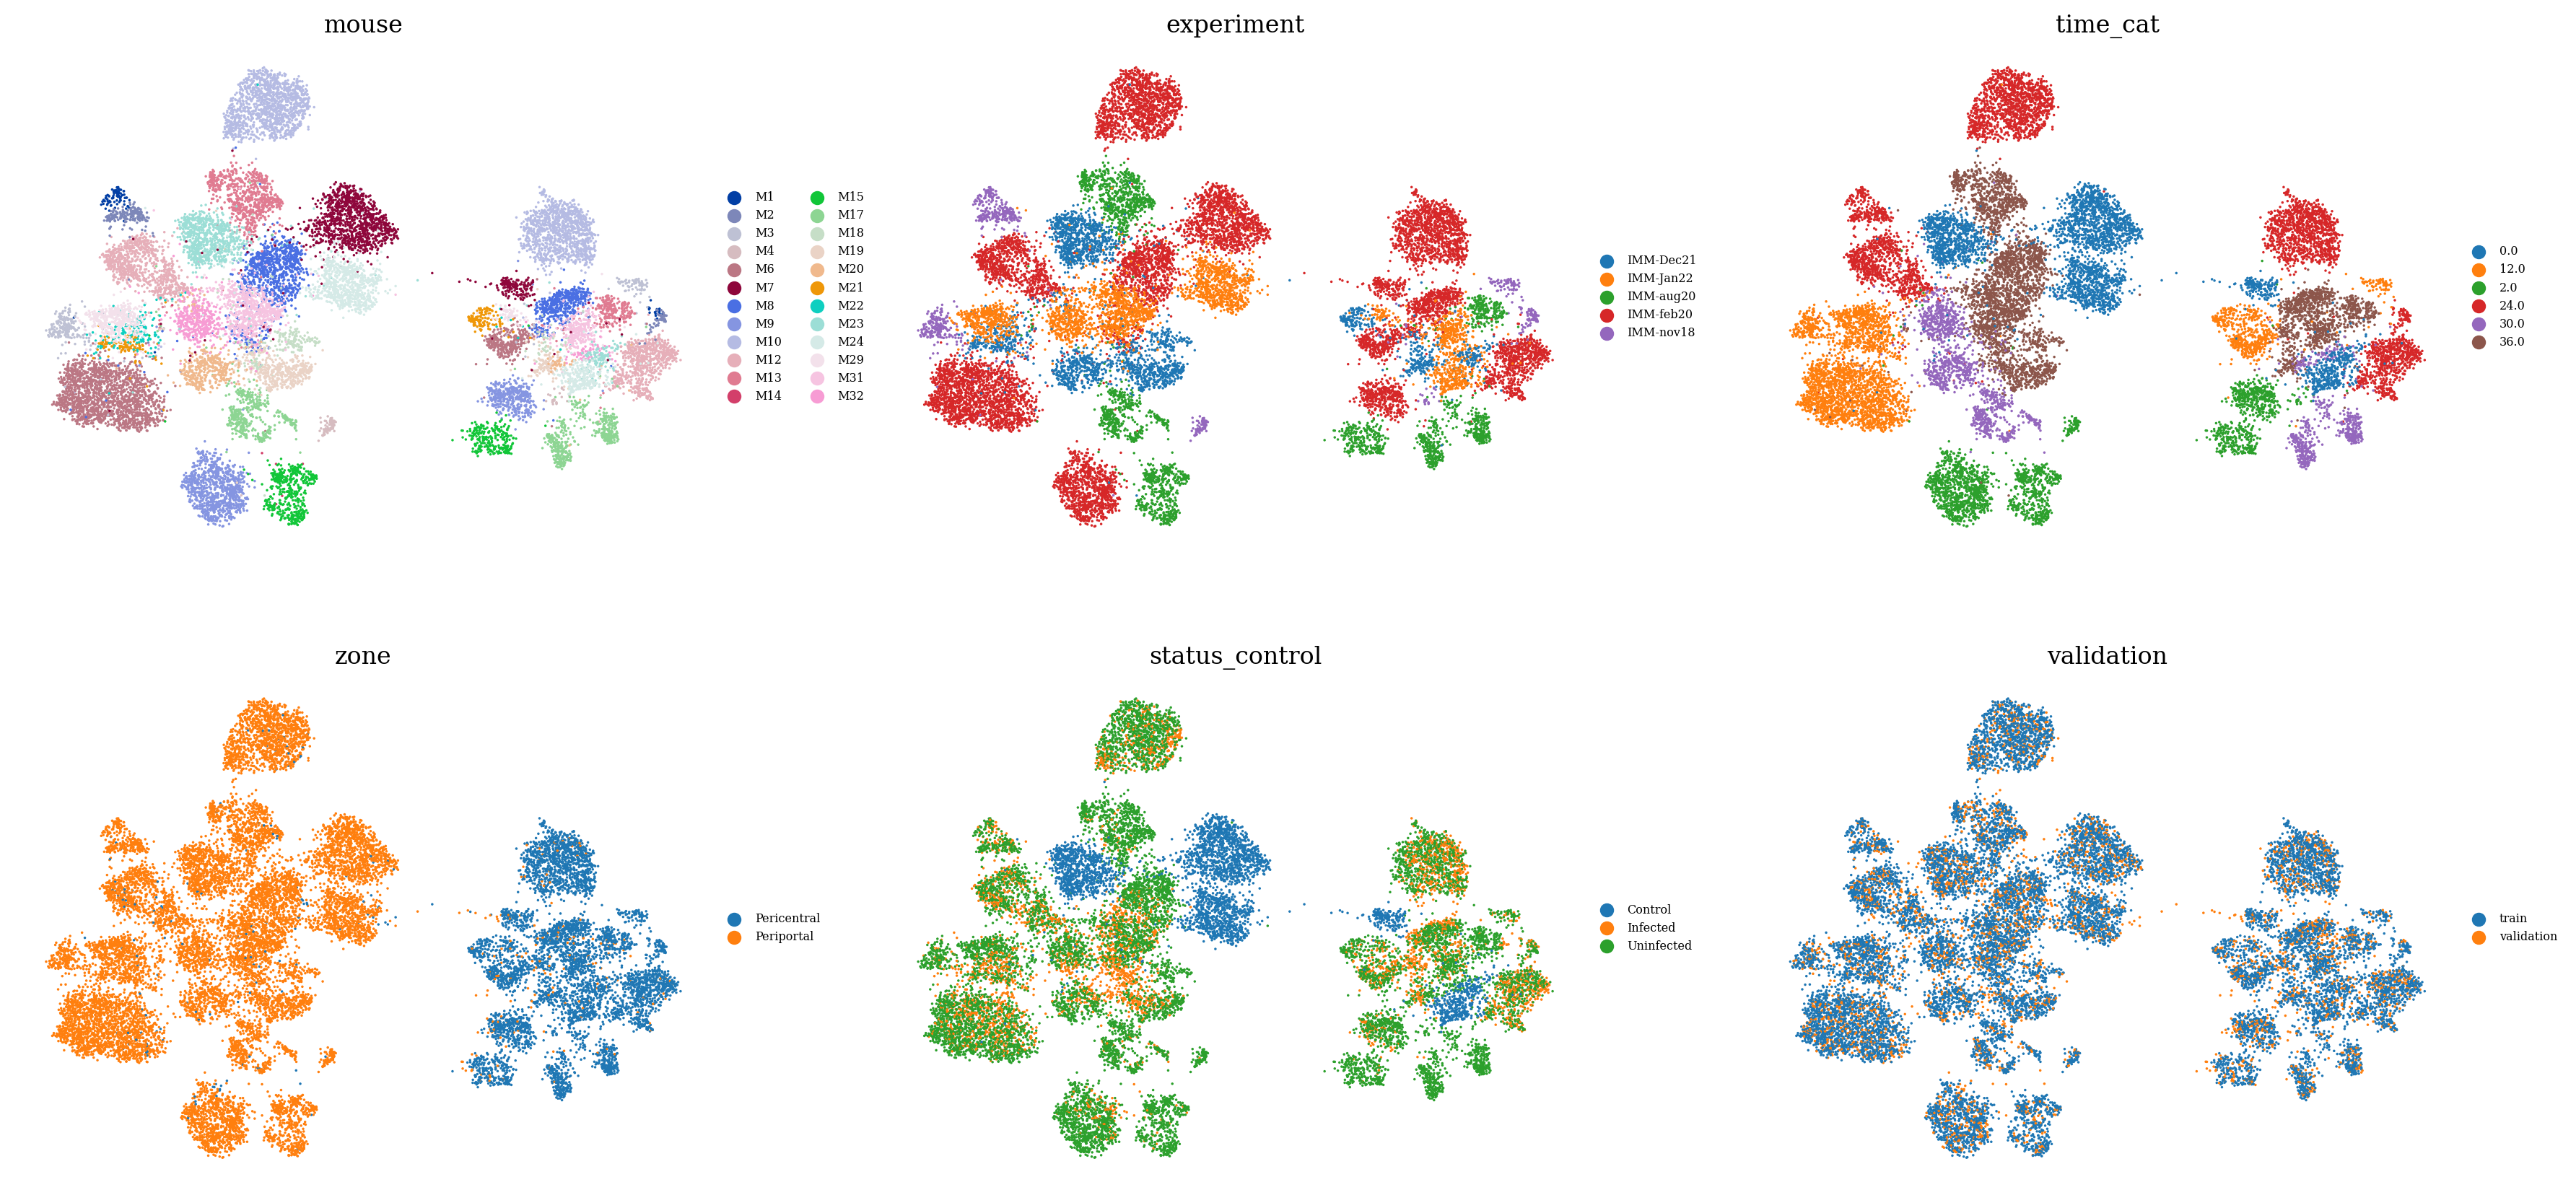

In [15]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [16]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [17]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


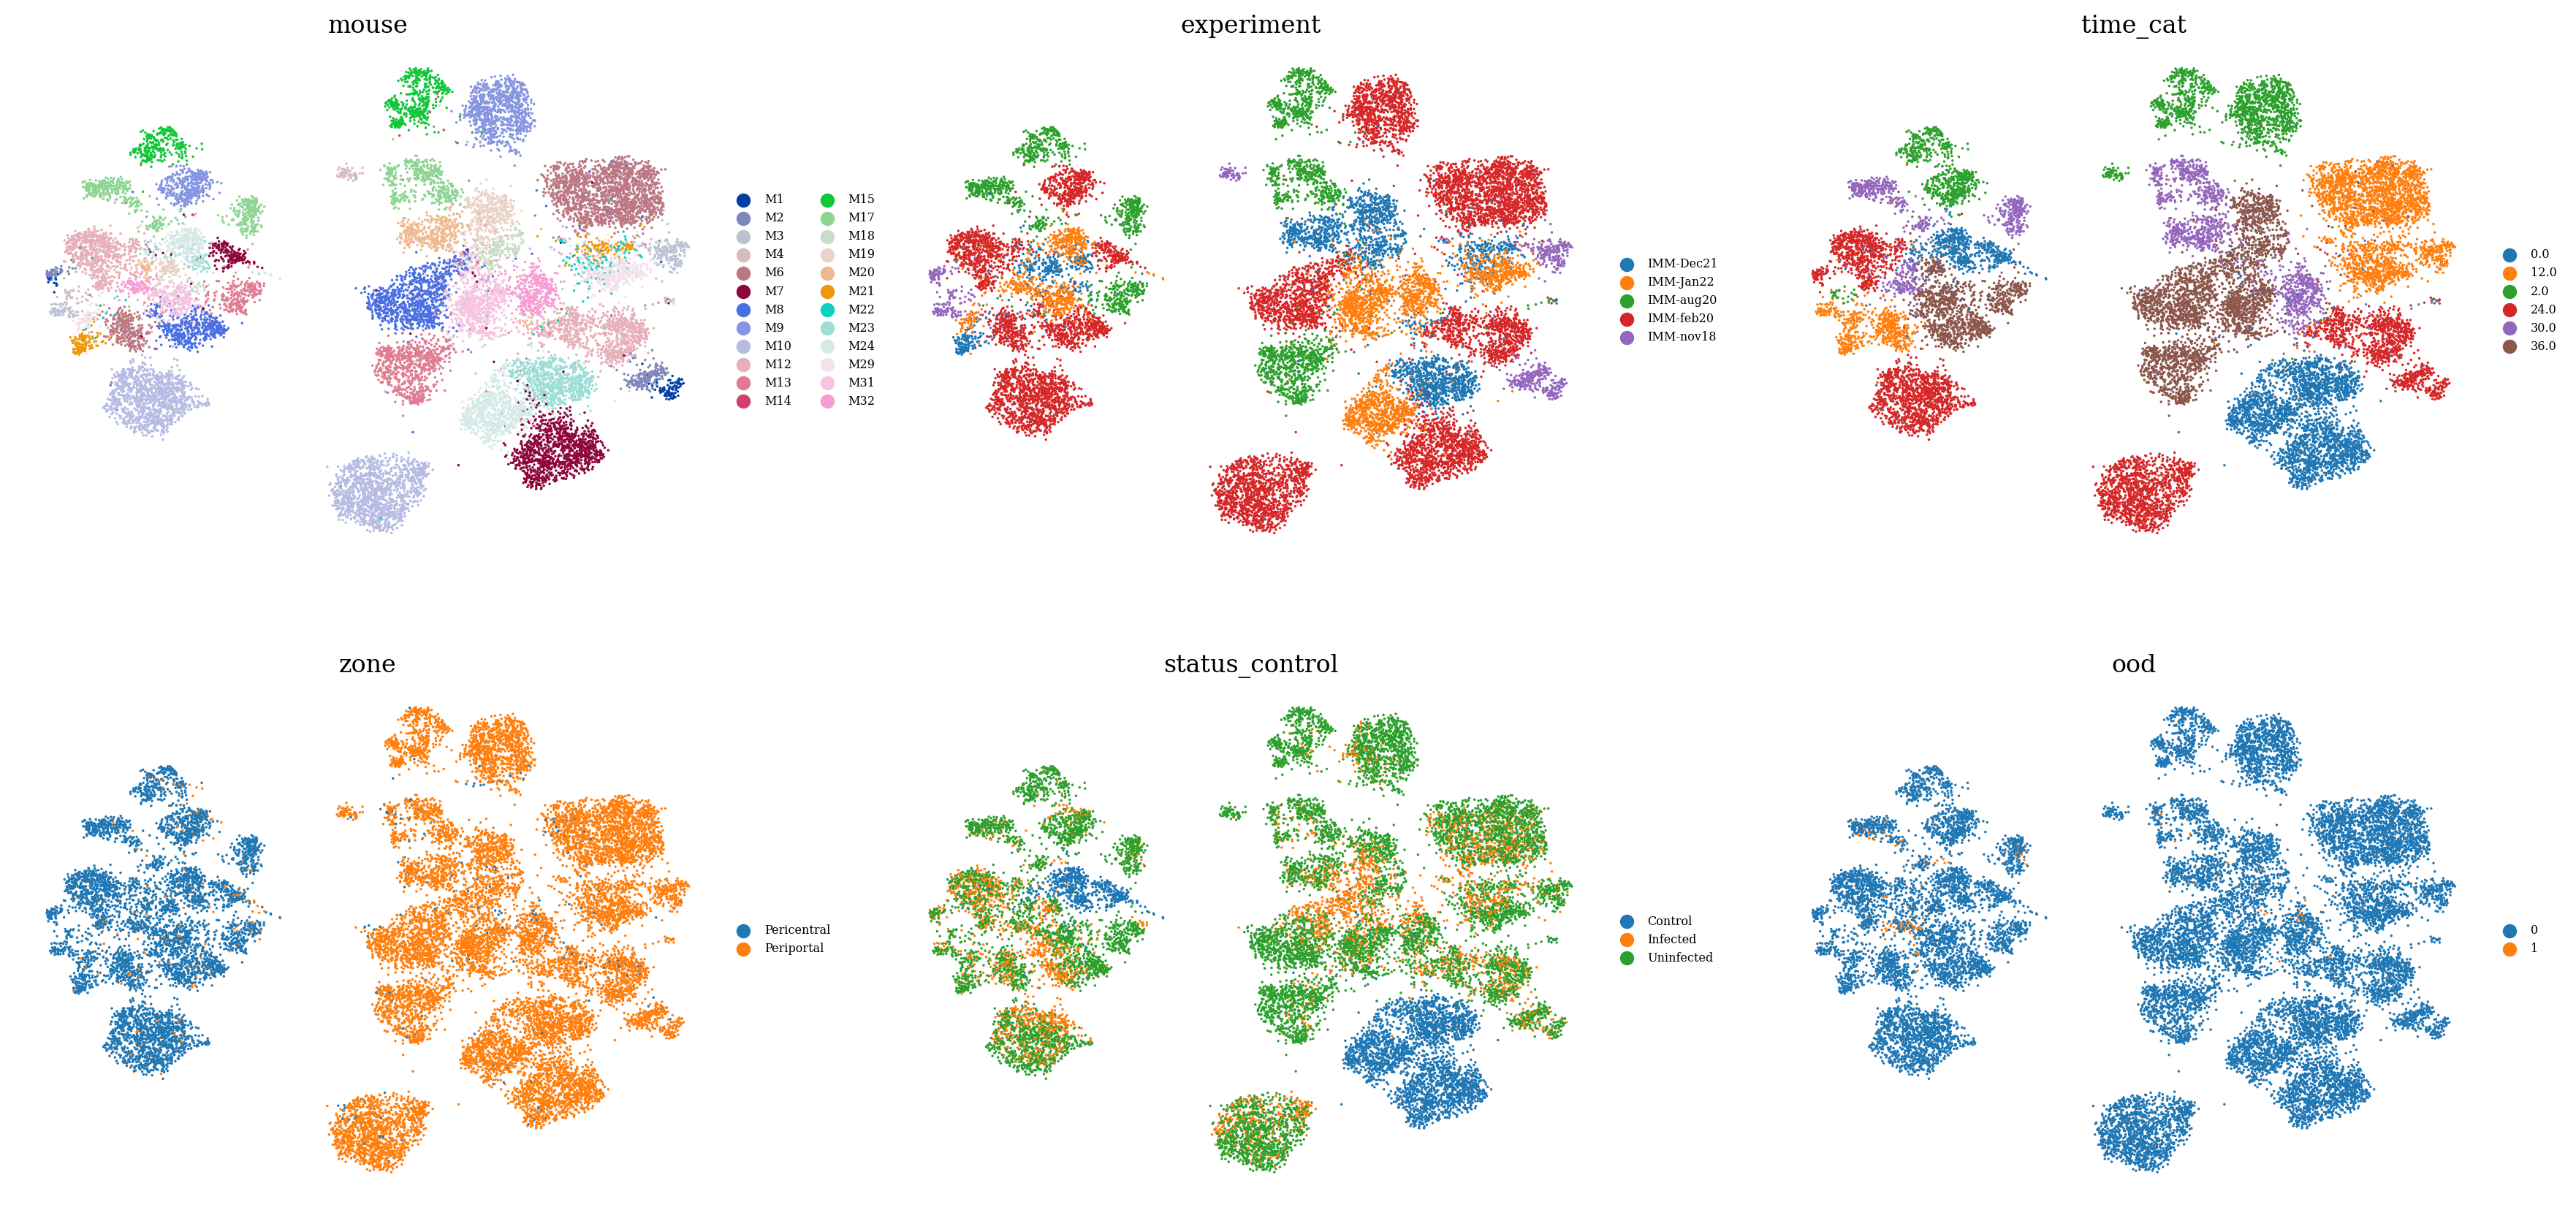

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [19]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.7069227943106072
F1 Weighted: 0.5855447461146036

Baseline Accuracy: 0.5855770744764603


F1 Weighted: 0.5856854986525758



{'accuracy': 0.7637362637362637,
 'precision_macro': 0.5,
 'recall_macro': 0.38186813186813184,
 'f1_score_macro': 0.43302180685358255,
 'precision_micro': 0.7637362637362637,
 'recall_micro': 0.7637362637362637,
 'f1_score_micro': 0.7637362637362637,
 'precision_weighted': 1.0,
 'recall_weighted': 0.7637362637362637,
 'f1_score_weighted': 0.8660436137071651,
 'confusion_matrix': array([[139,  43],
        [  0,   0]])}

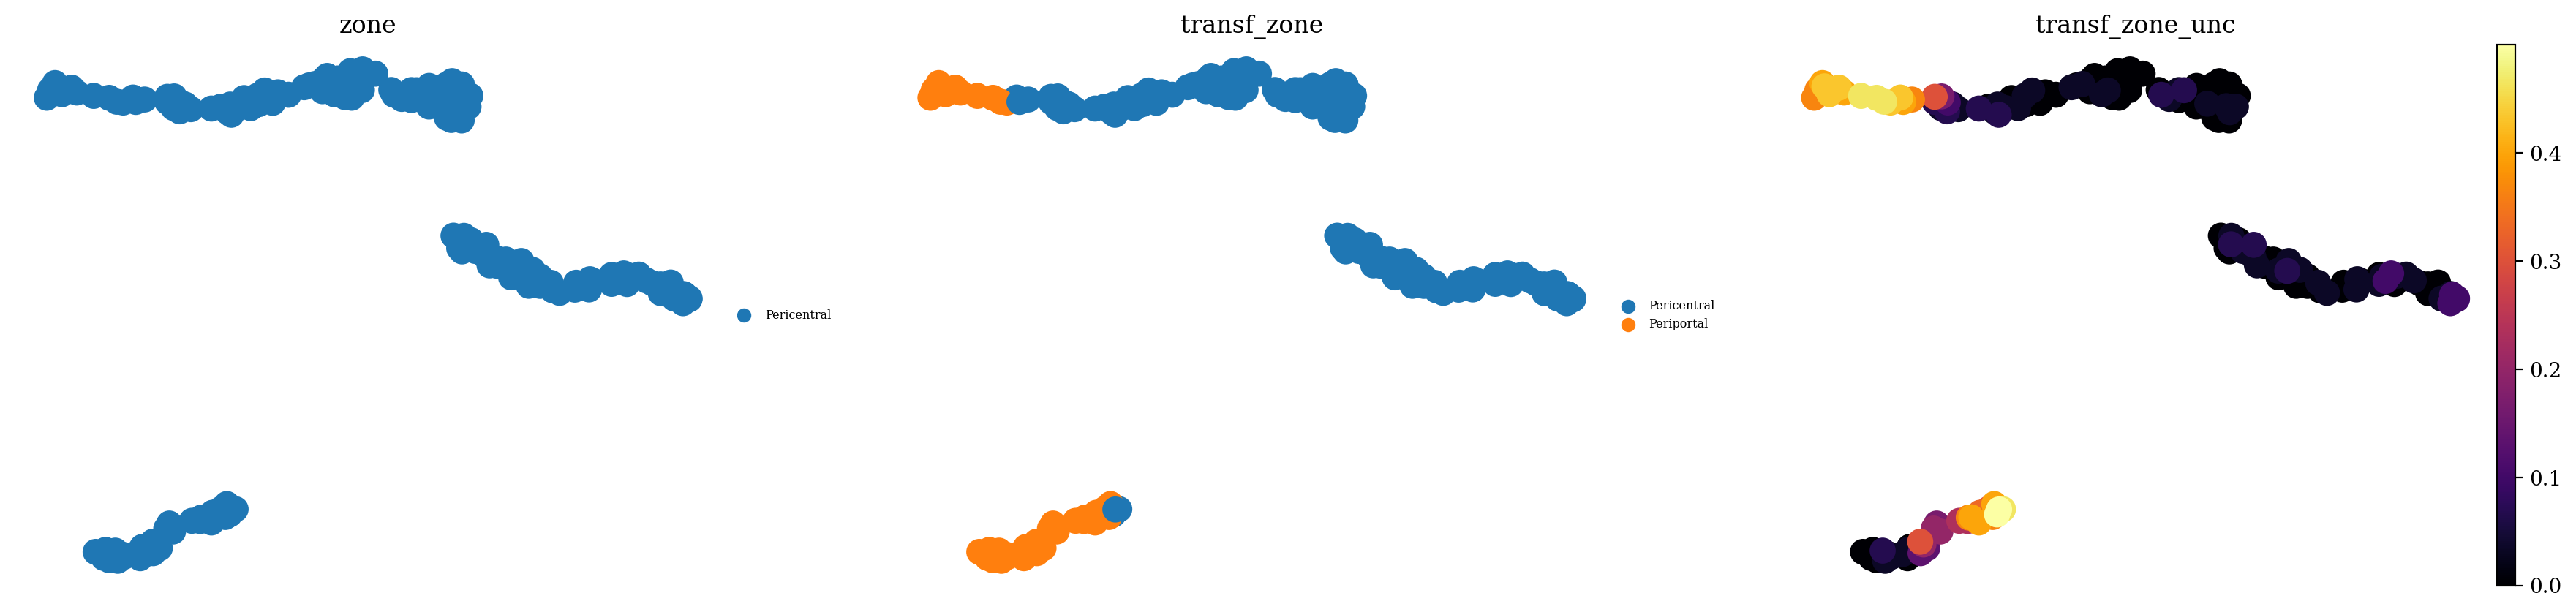

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )